In [1]:
import pandas as pd
cases = pd.read_csv('src/cases.csv',sep=';')
cases['Номер поручения']=cases['\ufeffНомер поручения']
marks = pd.read_csv('src/marks.csv',sep=';')
diaries = pd.read_csv('src/diaries.csv',sep=';')
# Переведём в числовой формат время выполнения задачи
diaries["Затрачено часов"] = diaries["Затрачено часов"].replace({r'[,]': '.'}, regex=True)
diaries['Затрачено часов']=diaries['Затрачено часов'].astype(float)

In [125]:
pd.set_option('display.max_colwidth', None)

In [330]:
data_cases = cases[['Номер поручения','Выполнено','Затрачено дней','Сумма вознаграждения','Описание']]
data_cases

,Номер поручения,Выполнено,Затрачено дней,Сумма вознаграждения,Описание
0,11000,да,4.0,6000,В лесу по дороге от пещеры звери нападают на л...
1,11001,да,2.0,20000,В лесу по дороге от пещеры были замечены разбо...
2,11002,да,7.0,22500,По дороге из деревни монстры похитили путников...
3,11003,да,5.0,5500,Недалеко от города видели монстров. Нужно побе...
4,11004,да,8.0,10500,В деревне у меня пропала сумка с документами. ...
...,...,...,...,...,...
495,11495,да,4.0,23000,В лесу около деревни встречаются звери. Нужно ...
496,11496,да,7.0,9000,В лесу между городом и деревней видели монстро...
497,11497,да,4.0,8000,В лесу по дороге от пещеры монстры нападают на...
498,11498,да,2.0,28000,В лесу около деревни разбойники нападают на лю...


In [332]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from natasha import Doc, Segmenter, NewsMorphTagger, NewsEmbedding, MorphVocab
import nltk
from nltk.corpus import stopwords

# Загрузка русских стоп-слов
nltk.download('stopwords')
stop_words = stopwords.words('russian')

# Настройка для лемматизации с помощью Natasha
segmenter = Segmenter()
morph_tagger = NewsMorphTagger(NewsEmbedding())
morph_vocab = MorphVocab()

def lemmatize_text_natasha(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    return ' '.join([token.lemma for token in doc.tokens])
data_cases['lemm']=data_cases['Описание'].fillna('').apply(lemmatize_text_natasha)
data_for_emb = data_cases['lemm'].unique()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\1\AppData\Local\Temp\ipykernel_17776\3266202796.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cases['lemm']=data_cases['Описание'].fillna('').apply(lemmatize_text_natasha)


In [ ]:
# data_cases['lemm']=data_cases['Описание'].fillna('').apply(lemmatize_text_natasha)
# data_for_emb = data_cases['lemm'].unique()

NameError: name 'lemmatize_text_natasha' is not defined

In [333]:
# Устанавливаем нужные библиотеки
from sentence_transformers import SentenceTransformer
import numpy as np

# Загружаем предобученную модель Sentence-BERT
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Легкая и быстрая модель

# Генерируем эмбеддинги для каждого предложения в столбце 'lemm'
embeddings = model.encode(data_for_emb)

# Преобразуем в массив numpy для последующей кластеризации
embeddings = np.array(embeddings)

# Проверим размерность эмбеддингов (должен быть массив с размерностью (число предложений, размер эмбеддинга))
print(embeddings.shape)


(243, 384)


## Рабочая кластеризация

In [339]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Преобразуем тексты в матрицу TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data_for_emb)

# Инициализируем и обучаем LDA
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(tfidf_matrix)

# Получаем распределение тем для каждого текста
lda_labels = lda.transform(tfidf_matrix)
topic_assignments = lda_labels.argmax(axis=1)

# Создаем DataFrame для анализа
data = pd.DataFrame({'text': data_for_emb, 'topic': topic_assignments})
# Получаем уникальные описания и их индексы
unique_lemm = data_cases['lemm'].unique()

# Создаем DataFrame для сопоставления уникальных описаний с метками кластеров
cluster_labels = pd.DataFrame({'lemm': unique_lemm, 'cluster': topic_assignments})

# Присоединяем метки кластеров к исходному датафрейму
data_cases = data_cases.merge(cluster_labels, on='lemm', how='left')

In [340]:
data_cases

,Номер поручения,Выполнено,Затрачено дней,Сумма вознаграждения,Описание,lemm,cluster
0,11000,да,4.0,6000,В лесу по дороге от пещеры звери нападают на л...,в лес по дорога от пещера зверь нападать на че...,2
1,11001,да,2.0,20000,В лесу по дороге от пещеры были замечены разбо...,в лес по дорога от пещера быть заметить разбой...,2
2,11002,да,7.0,22500,По дороге из деревни монстры похитили путников...,по дорога из деревня монстр похитить путник . ...,1
3,11003,да,5.0,5500,Недалеко от города видели монстров. Нужно побе...,недалеко от город видеть монстр . нужный побед...,1
4,11004,да,8.0,10500,В деревне у меня пропала сумка с документами. ...,в деревня у я пропасть сумка с документ . нужн...,0
...,...,...,...,...,...,...,...
495,11495,да,4.0,23000,В лесу около деревни встречаются звери. Нужно ...,в лес около деревня встречаться зверь . нужный...,2
496,11496,да,7.0,9000,В лесу между городом и деревней видели монстро...,в лес между город и деревня видеть монстр . ну...,1
497,11497,да,4.0,8000,В лесу по дороге от пещеры монстры нападают на...,в лес по дорога от пещера монстр нападать на ч...,2
498,11498,да,2.0,28000,В лесу около деревни разбойники нападают на лю...,в лес около деревня разбойник нападать на чело...,2


In [342]:
data_cases[data_cases['cluster']==0][['cluster','lemm']]

,cluster,lemm
4,0,в деревня у я пропасть сумка с документ . нужн...
8,0,недалеко от город у я потеряться драгоценность...
19,0,в город у я пропасть сумка с документ . нужный...
23,0,в деревня у я потеряться рюкзак . нужный найти...
25,0,в деревня у я быть украсть сумка с документ . ...
...,...,...
481,0,в город у я потеряться драгоценность . нужный ...
485,0,в деревня у я быть украсть рюкзак . нужный вер...
486,0,в деревня у я пропасть рюкзак . нужный вернуть...
492,0,по дорога из деревня у я быть украсть драгоцен...


In [344]:
unique_data_cases = data_cases.drop_duplicates(subset='Описание').reset_index(drop=True)

In [345]:
# Список ключевых слов для каждой группы
keywords = {
    1: ['пропасть', 'потеряться', 'украсть', 'драгоценность','сумка','рюкзак'],
    2: ['похитить ', 'путник', 'освободить','спасти'],
    3: ['опасный'],
    4: ['найти зверь','найти монстр','найти разбойник','найти разбойник',],
    
    # Добавьте другие группы и ключевые слова по необходимости
}

# Функция для определения группы на основе наличия ключевых слов
def assign_group(description):
    for group, words in keywords.items():
        if any(word in description for word in words):
            return group
    return 0  # Если ни одно слово не найдено, помечаем как 0 (нет группы)

# Применяем функцию к столбцу 'Описание' и создаем новый столбец 'group'
unique_data_cases['group'] = unique_data_cases['lemm'].apply(assign_group)

In [348]:
unique_data_cases[unique_data_cases['group']==0]

,Номер поручения,Выполнено,Затрачено дней,Сумма вознаграждения,Описание,lemm,cluster,group
5,11005,да,4.0,9000,В лесу недалеко от города заметили зверей. Нуж...,в лес недалеко от город заметить зверь . нужны...,2,0
6,11006,да,8.0,8000,В пещере появвилось огромное каменное чудовище...,в пещера появвиться огромный каменный чудовище...,3,0
8,11009,да,2.0,28500,В пещере появвилось огромное каменное чудовище...,в пещера появвиться огромный каменный чудовище...,3,0
11,11012,да,4.0,11000,В пещере завёлся дракон. Нужно его убить.,в пещера завестись дракон . нужный он убить .,3,0
12,11013,да,10.0,24500,В лесу около деревни разбойники нападают на лю...,в лес около деревня разбойник нападать на чело...,2,0
...,...,...,...,...,...,...,...,...
224,11440,да,5.0,28500,Недалеко от города заметили разбойников. Нужно...,недалеко от город заметить разбойник . нужный ...,2,0
225,11441,да,10.0,7000,В лесу недалеко от города видели монстров. Нуж...,в лес недалеко от город видеть монстр . нужный...,1,0
226,11443,да,5.0,16500,По дороге из деревни заметили зверей. Нужно пр...,по дорога из деревня заметить зверь . нужный п...,2,0
238,11484,да,1.0,29000,В лесу по дороге от пещеры разбойники нападают...,в лес по дорога от пещера разбойник нападать н...,2,0


In [268]:
with open("всё остальное.txt", "w") as f:
    for item in unique_data_cases[unique_data_cases['group']==0]['Описание'].tolist():
        f.write("%s\n" % item)

Text(0.5, 1.0, 'Зачистка')

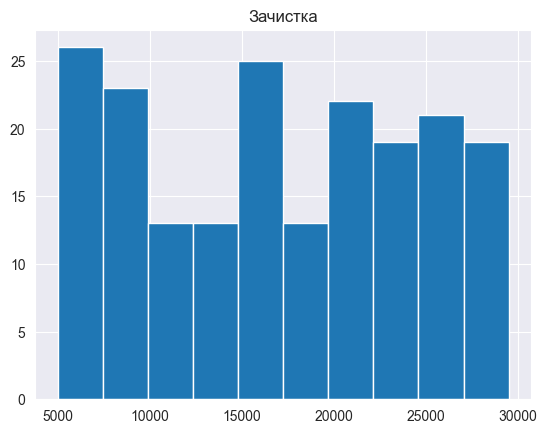

In [267]:
data_cases[data_cases['group']==0]['Сумма вознаграждения'].hist()
import matplotlib.pyplot as plt
plt.title('Зачистка')

In [ ]:
all_data = pd.read_csv('all_data.csv')
del all_data['Unnamed: 0']


# Созданиие первой таблицы героев

In [78]:
# Группируем данные по герою и группе, вычисляя средние значения и количество для каждого показателя
grouped = (
    all_data.groupby(['Герой', 'group'])[['Оценка за качество', 'Оценка по срокам', 'Оценка за вежливость','Затрачено дней']]
    .agg('mean')
)
# "Расплавляем" MultiIndex столбцы и "вытягиваем" данные в строку, как при one-hot encoding
hero_data = grouped.reset_index()

In [81]:
hero_data

,Герой,group,Оценка за качество,Оценка по срокам,Оценка за вежливость,Затрачено дней
0,Агата,0,3.916667,3.416667,4.583333,5.166667
1,Агата,1,3.818182,3.909091,4.090909,5.555556
2,Агата,2,4.000000,3.400000,3.200000,6.250000
3,Агата,3,4.666667,4.666667,3.666667,3.333333
4,Агата,4,3.500000,4.000000,2.500000,4.500000
5,Альфред,0,3.941176,3.529412,3.764706,4.823529
6,Альфред,1,3.428571,3.285714,4.285714,7.166667
7,Альфред,2,4.166667,4.000000,4.000000,5.666667
8,Альфред,3,4.142857,4.142857,3.714286,5.428571
9,Альфред,4,3.000000,4.000000,4.000000,4.500000


In [ ]:
diaries = pd.merge(diaries,all_data[['group','Номер поручения']], on='Номер поручения')

In [75]:
diaries[diaries['group']==4]['Запись в дневнике'].unique()

array(['разжечь костёр', 'выследить цель'], dtype=object)

In [71]:
all_data[all_data['group']==3]

,Номер поручения,Выполнено,Затрачено дней,Сумма вознаграждения,Описание,lemm,group,Герой,Оценка за качество,Оценка по срокам,Оценка за вежливость
1,11001,да,2.0,20000,В лесу по дороге от пещеры были замечены разбо...,в лес по дорога от пещера быть заметить разбой...,3,Альфред,5,5,4
3,11003,да,5.0,5500,Недалеко от города видели монстров. Нужно побе...,недалеко от город видеть монстр . нужный побед...,3,Бендер,2,4,3
10,11010,да,4.0,22500,Недалеко от города встречаются звери. Нужно уб...,недалеко от город встречаться зверь . нужный у...,3,Альфред,4,4,5
11,11011,да,3.0,6500,Недалеко от города заметили разбойников. Нужно...,недалеко от город заметить разбойник . нужный ...,3,Альфред,4,4,3
37,11037,да,1.0,6500,В пещере появвилось огромное каменное чудовище...,в пещера появвиться огромный каменный чудовище...,3,Фредерик,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...
478,11478,да,10.0,24000,В пещере завёлся дракон. Нужно его уничтожить....,в пещера завестись дракон . нужный он уничтожи...,3,Соня,5,3,5
482,11482,да,2.0,18000,В лесу около деревни видели монстров. Нужно ун...,в лес около деревня видеть монстр . нужный уни...,3,Пастушок,4,4,3
483,11483,да,5.0,24500,В пещере завёлся дракон. Нужно его убить. Это ...,в пещера завестись дракон . нужный он убить . ...,3,Пастушок,3,5,4
487,11487,да,3.0,17500,По дороге из деревни заметили разбойников. Нуж...,по дорога из деревня заметить разбойник . нужн...,3,Глюкоза,4,4,4


# Создание второй таблицы героев

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Исходные данные
# Здесь подключение ваших таблиц `diaries`

# Действия для общей таблицы
actions = ['выследить цель', 'залечить раны', 'найти пропажу', 'отыскать заказчика']

# Фильтрация по целевым действиям
filtered_diaries = diaries[diaries['Запись в дневнике'].isin(actions)]

# Группировка по 'Герой' и 'Запись в дневнике', вычисление среднего по 'Затрачено часов'
average_hours = filtered_diaries.groupby(['Герой', 'Запись в дневнике'])['Затрачено часов'].mean().unstack()
average_hours.columns.name = None  # Убираем имя индекса
average_hours.reset_index(inplace=True)
average_hours.fillna(0, inplace=True)

# Инвертирование значений и нормализация
average_hours = 1 / average_hours.set_index('Герой').replace(0, float('nan'))
scaler = MinMaxScaler(feature_range=(1, 5))
scaled_values = scaler.fit_transform(average_hours)
scaled_average_hours = pd.DataFrame(scaled_values, columns=average_hours.columns, index=average_hours.index)
scaled_average_hours.reset_index(inplace=True)
scaled_average_hours.fillna(0, inplace=True)

# Минимальные значения для действия "разжечь костёр" по ролям
filtered_diaries_bonfire = diaries[diaries['Запись в дневнике'] == 'разжечь костёр']
average_bonfire = filtered_diaries_bonfire.groupby(['Герой', 'Роль'])['Затрачено часов'].mean().reset_index()

# Выбор роли с минимальным средним значением по каждому герою для "разжечь костёр"
min_bonfire_role = average_bonfire.loc[average_bonfire.groupby('Герой')['Затрачено часов'].idxmin()]
min_bonfire_role = min_bonfire_role.rename(columns={ 'Роль': 'Роль (разжечь костёр)','Затрачено часов': 'разжечь костёр'})

# Объединение таблиц по 'Герой'
final_table = pd.merge(scaled_average_hours, min_bonfire_role[['Герой','разжечь костёр','Роль (разжечь костёр)']], on='Герой', how='left')
# Инвертирование значений (где значения не равны нулю)
final_table['разжечь костёр'] = 1 / final_table['разжечь костёр'].replace(0, float('nan'))

# Применение Min-Max нормализации к столбцу "разжечь костёр"
scaler = MinMaxScaler(feature_range=(1, 5))
final_table['разжечь костёр'] = scaler.fit_transform(final_table[['разжечь костёр']])*0.5 #понижаю значимость признака, так как само действие не важное, но может вносить сильный вклад в выбор персонажа
final_table


,Герой,выследить цель,залечить раны,найти пропажу,отыскать заказчика,разжечь костёр,Роль (разжечь костёр)
0,Агата,5.0,0.0,5.0,5.0,2.5,лучник
1,Альфред,5.0,1.0,5.0,5.0,0.5,рейнджер
2,Бендер,1.0,0.0,1.0,1.0,2.5,мечник
3,Бенедикт,3.0,5.0,3.0,3.0,2.5,рейнджер
4,Глюкоза,3.0,0.0,3.0,3.0,2.5,боевой маг
5,Леопольд,3.0,0.0,3.0,3.0,0.5,мечник
6,Мартин,3.0,1.0,3.0,3.0,0.5,лучник
7,Пастушок,1.0,0.0,1.0,1.0,2.5,мечник
8,Синеглазый,3.0,1.0,3.0,3.0,2.5,рейнджер
9,Соня,3.0,3.0,3.0,3.0,0.5,боевой маг


In [111]:
# Фильтрация датафрейма для записей, где действия входят в указанный список
actions = ['выследить цель', 'залечить раны', 'найти пропажу', 'отыскать заказчика']
filtered_diaries = diaries[diaries['Запись в дневнике'].isin(actions)]

# Группировка по колонкам 'Герой' и 'Запись в дневнике' и вычисление среднего значения по 'Затрачено часов'
average_hours = filtered_diaries.groupby(['Герой', 'Запись в дневнике'])['Затрачено часов'].mean().unstack()

# Переименуем столбцы для наглядности
average_hours.columns.name = None
average_hours.reset_index(inplace=True)
average_hours.fillna(0,inplace=True)
average_hours
from sklearn.preprocessing import MinMaxScaler

# Инвертирование среднего значения для каждого действия
# (где значения не равны нулю, чтобы избежать деления на ноль)
average_hours = 1 / average_hours.set_index('Герой').replace(0, float('nan'))

# Применение Min-Max нормализации к интервалу от 0 до 5
scaler = MinMaxScaler(feature_range=(1, 5))
scaled_values = scaler.fit_transform(average_hours)

# Формирование датафрейма с отмасштабированными значениями
scaled_average_hours = pd.DataFrame(scaled_values, columns=average_hours.columns, index=average_hours.index)

# Сброс индекса для финальной таблицы
scaled_average_hours.reset_index(inplace=True)
scaled_average_hours.fillna(0,inplace=True)
scaled_average_hours

,Герой,выследить цель,залечить раны,найти пропажу,отыскать заказчика
0,Агата,5.0,0.0,5.0,5.0
1,Альфред,5.0,1.0,5.0,5.0
2,Бендер,1.0,0.0,1.0,1.0
3,Бенедикт,3.0,5.0,3.0,3.0
4,Глюкоза,3.0,0.0,3.0,3.0
5,Леопольд,3.0,0.0,3.0,3.0
6,Мартин,3.0,1.0,3.0,3.0
7,Пастушок,1.0,0.0,1.0,1.0
8,Синеглазый,3.0,1.0,3.0,3.0
9,Соня,3.0,3.0,3.0,3.0


In [20]:
hero_data

,Герой,group,Оценка за качество,Оценка по срокам,Оценка за вежливость
0,Агата,0,3.916667,3.416667,4.583333
1,Агата,1,3.818182,3.909091,4.090909
2,Агата,2,4.000000,3.400000,3.200000
3,Агата,3,4.666667,4.666667,3.666667
4,Агата,4,3.500000,4.000000,2.500000
5,Альфред,0,3.941176,3.529412,3.764706
6,Альфред,1,3.428571,3.285714,4.285714
7,Альфред,2,4.166667,4.000000,4.000000
8,Альфред,3,4.142857,4.142857,3.714286
9,Альфред,4,3.000000,4.000000,4.000000


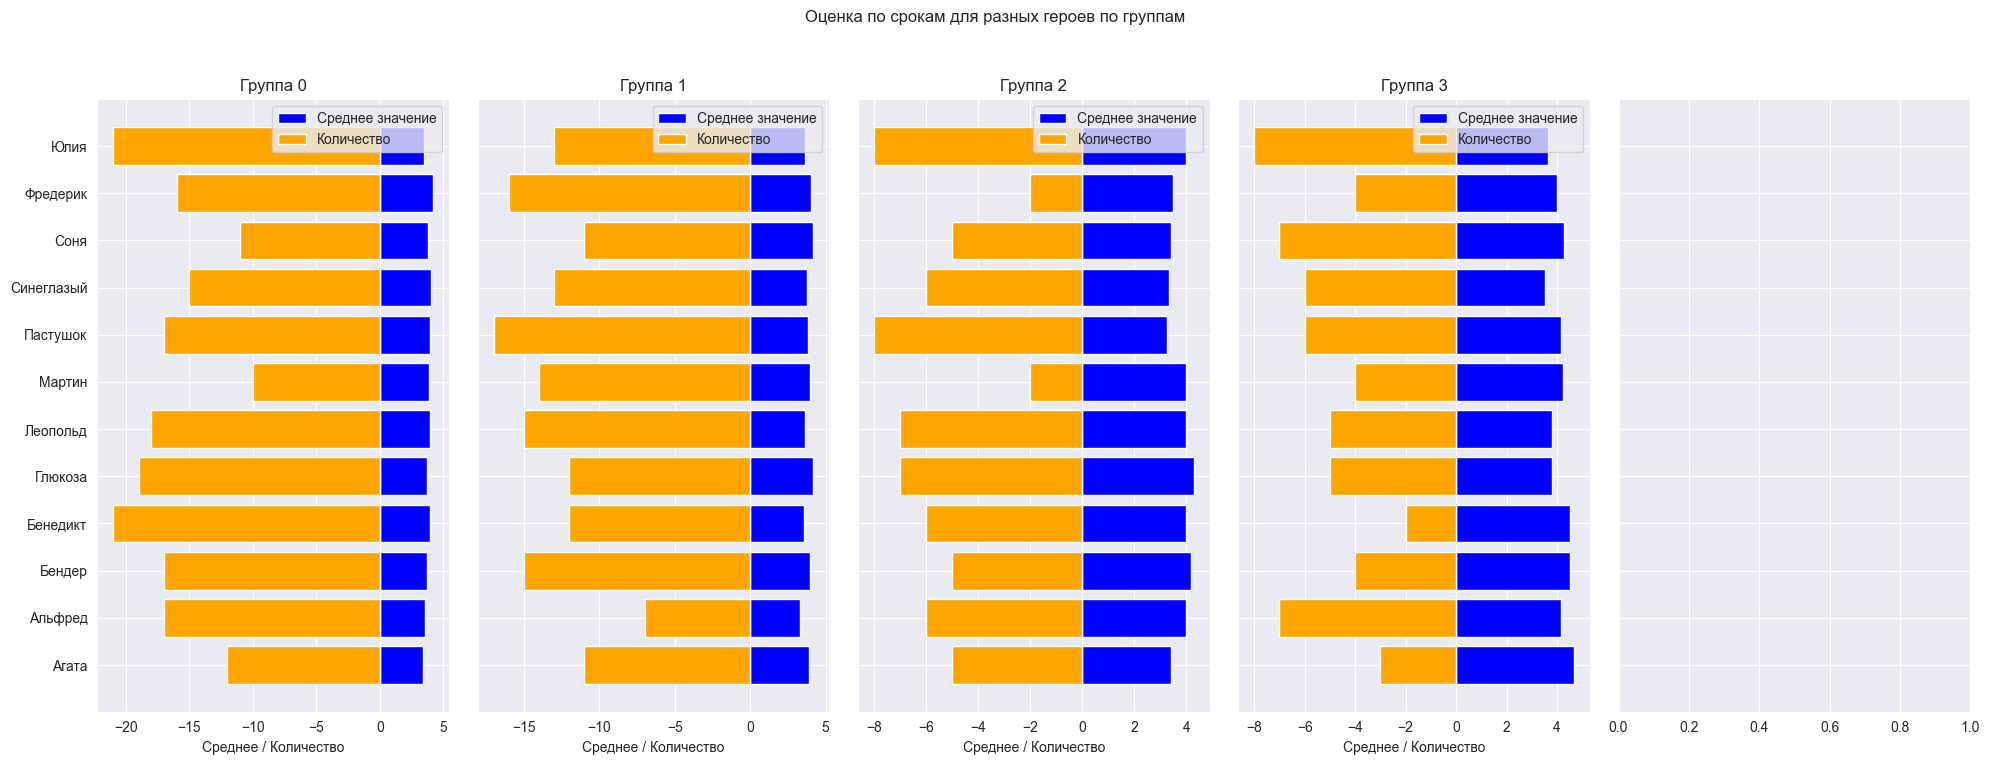

In [309]:
import matplotlib.pyplot as plt
import numpy as np

# Фильтруем только данные по "Оценка по срокам"
columns_to_plot = [col for col in hero_data.columns if 'Оценка по срокам' in col]
mean_columns = [col for col in columns_to_plot if 'mean' in col]
count_columns = [col for col in columns_to_plot if 'count' in col]

# Устанавливаем размеры фигуры и стиль
fig, axes = plt.subplots(1, 5, figsize=(20, 8), sharey=True)
fig.suptitle("Оценка по срокам для разных героев по группам")

# Создаем графики по каждой группе
for i, group in enumerate(range(0, 4)):
    mean_col = f'Оценка по срокам_mean_{group}'
    count_col = f'Оценка по срокам_count_{group}'

    # Проверка, что нужные столбцы есть в данных
    if mean_col in hero_data.columns and count_col in hero_data.columns:
        mean_values = hero_data[mean_col]
        count_values = hero_data[count_col]
        
        # Создаем горизонтальные бар-графики в противоположные стороны
        axes[i].barh(hero_data['Герой'], mean_values, color='blue', label='Среднее значение')
        axes[i].barh(hero_data['Герой'], -count_values, color='orange', label='Количество')
        
        # Устанавливаем подписи и заголовки
        axes[i].set_title(f'Группа {group}')
        axes[i].set_xlabel("Среднее / Количество")
        axes[i].legend(loc="upper right")

# Показ графиков
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


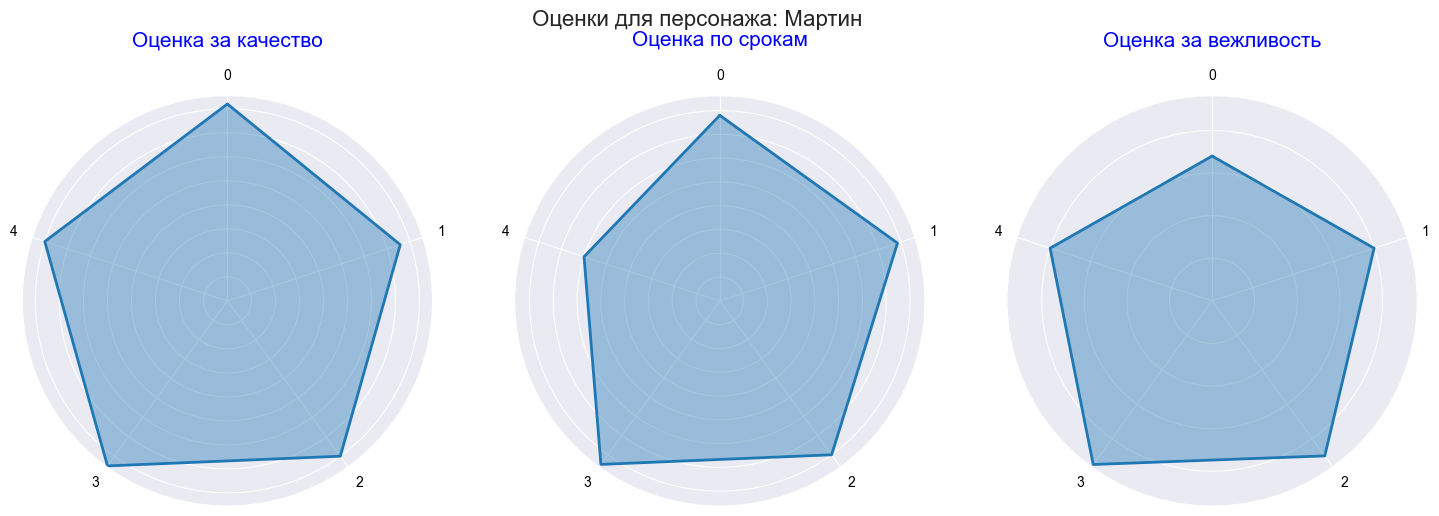

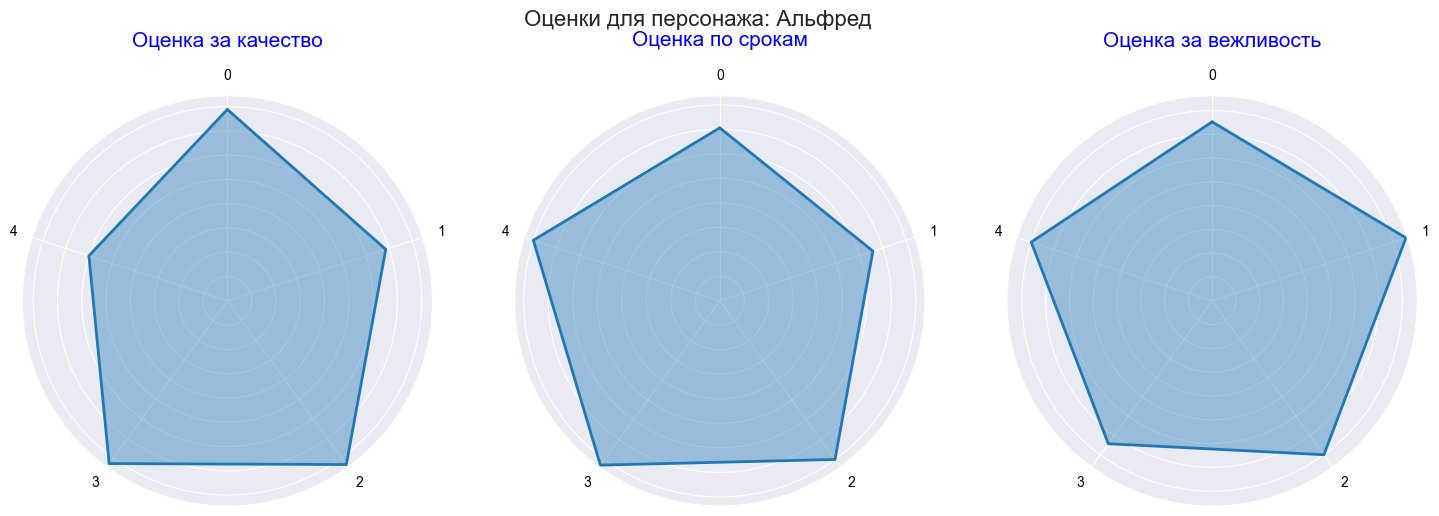

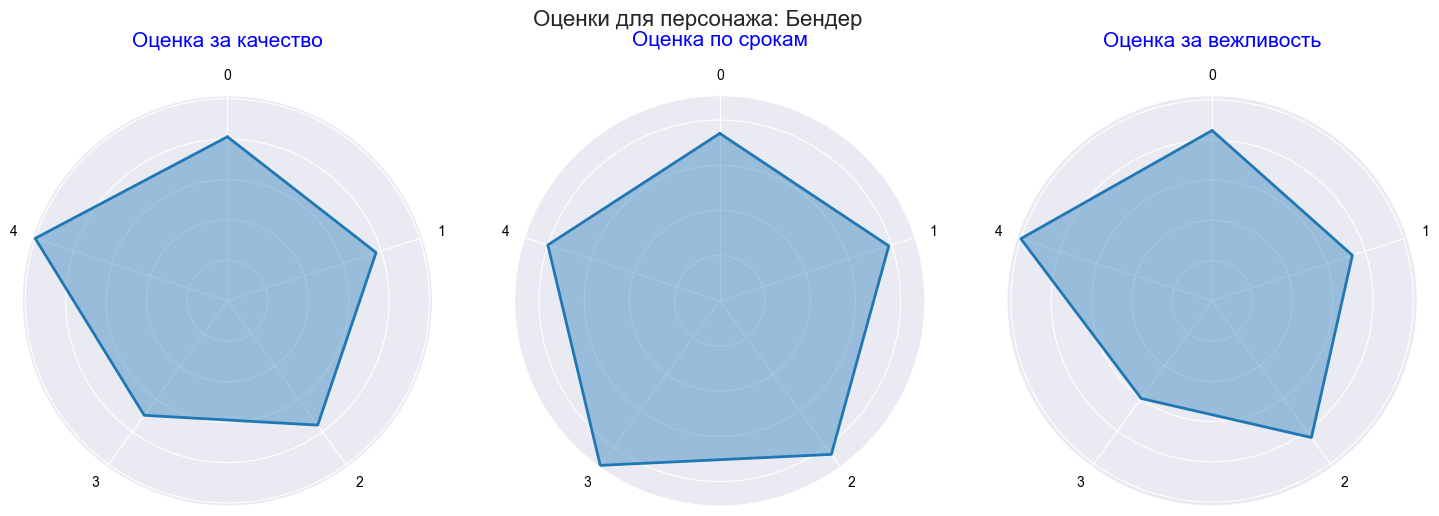

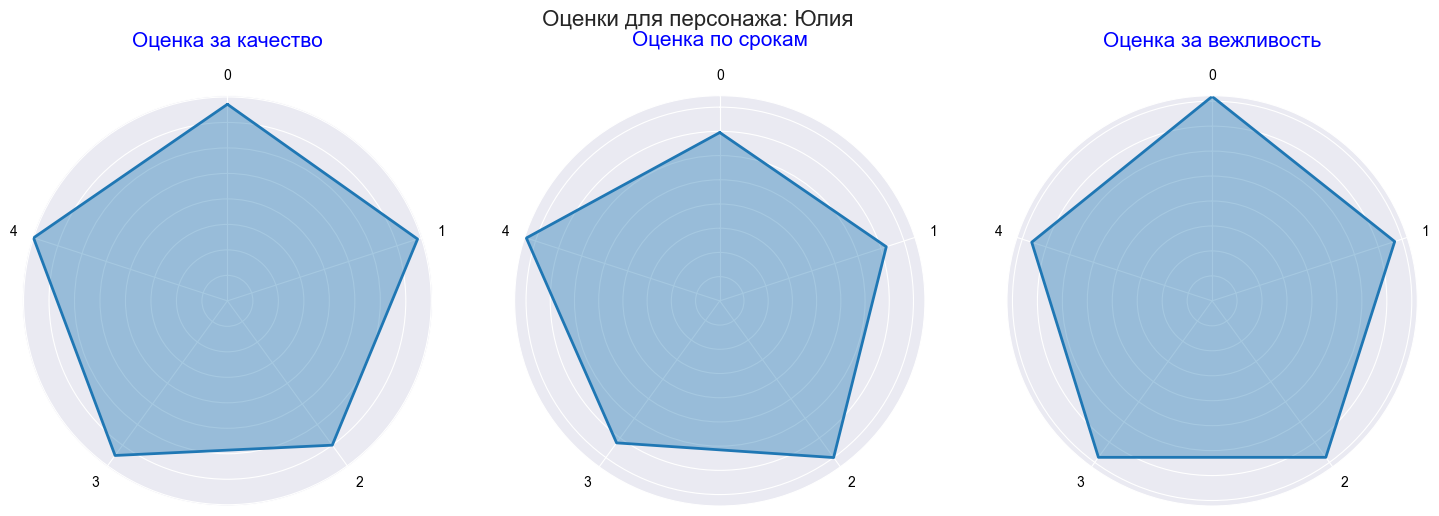

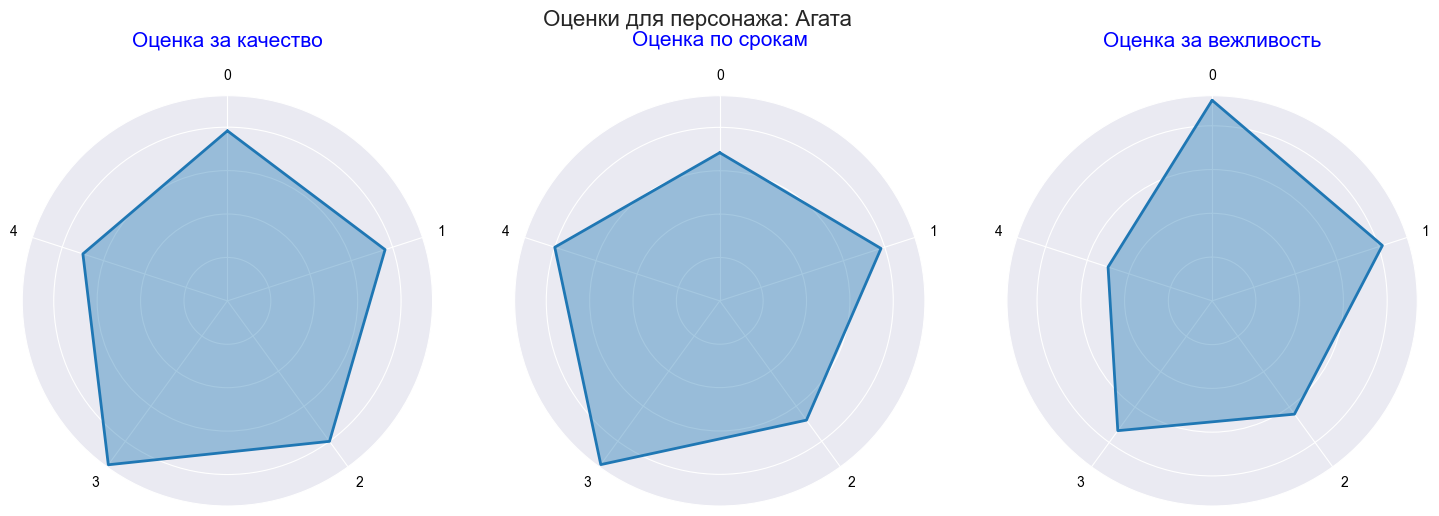

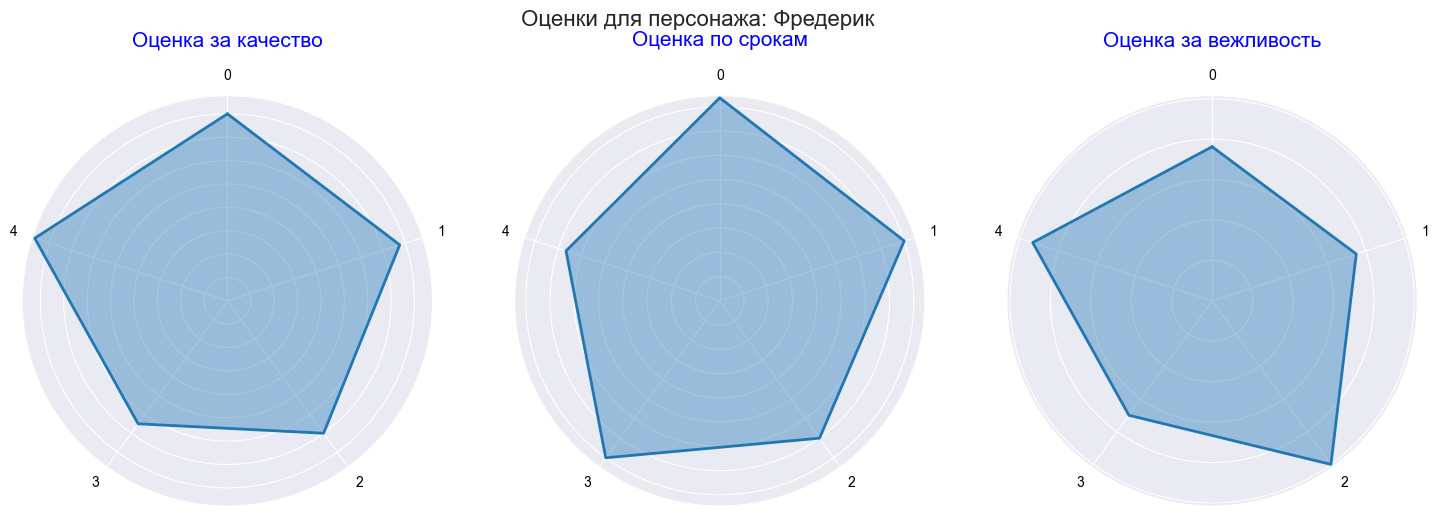

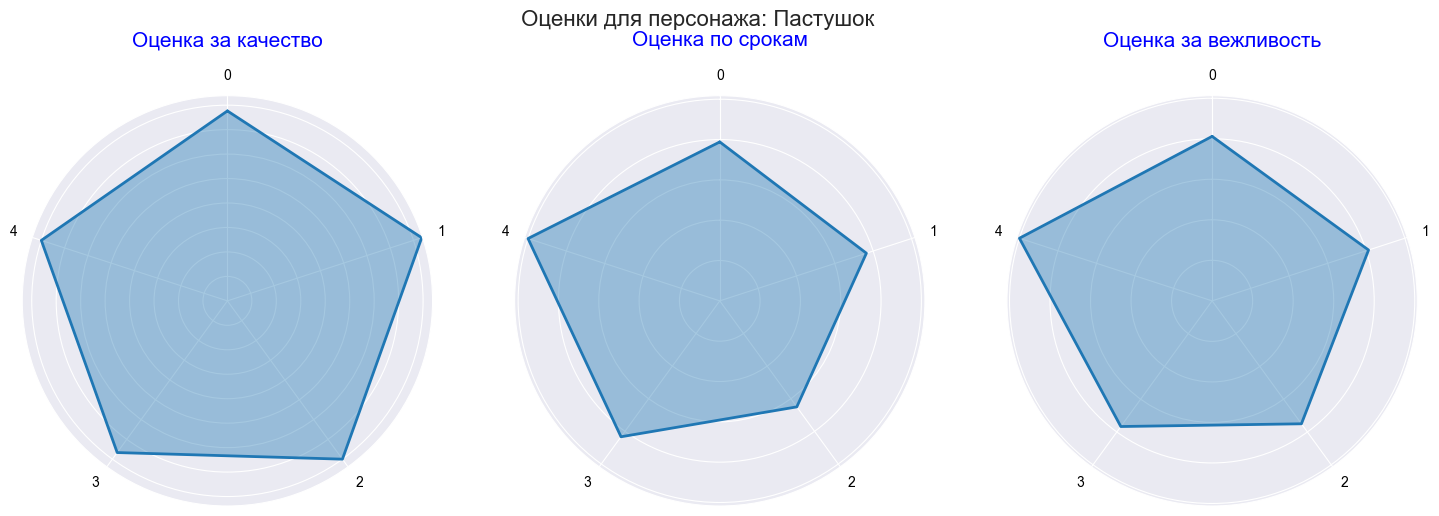

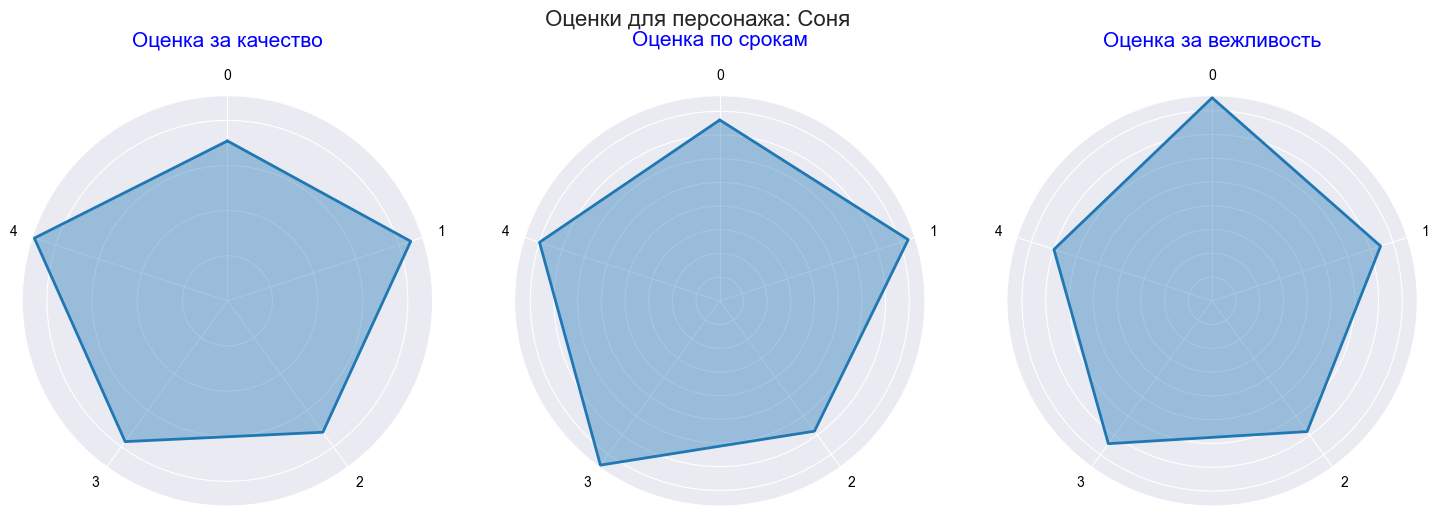

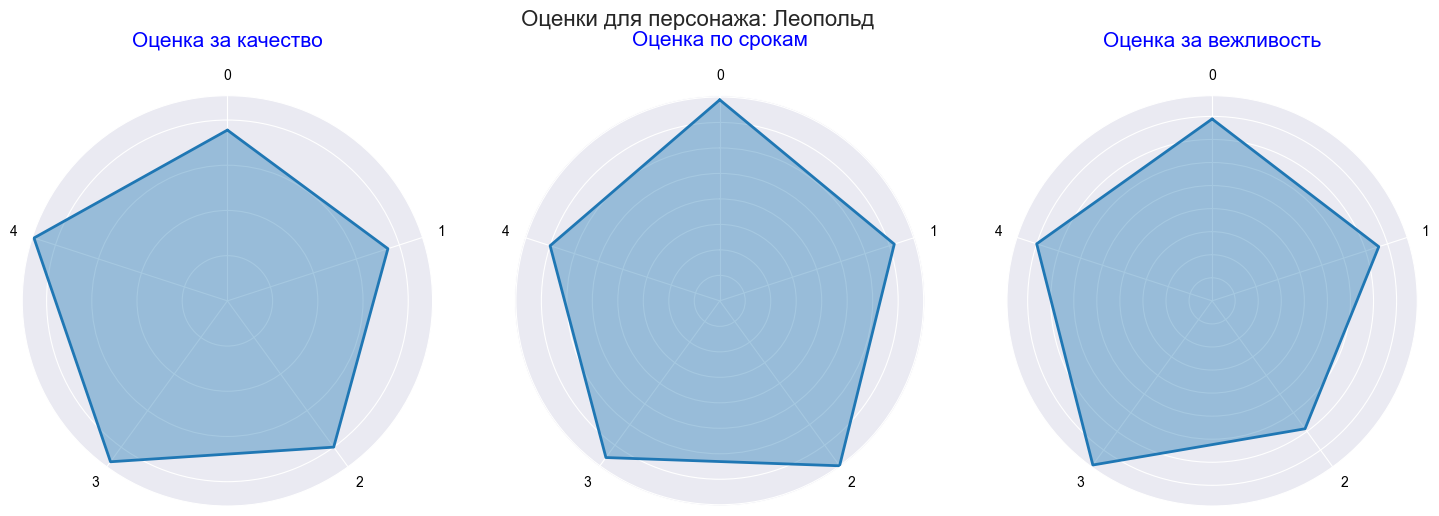

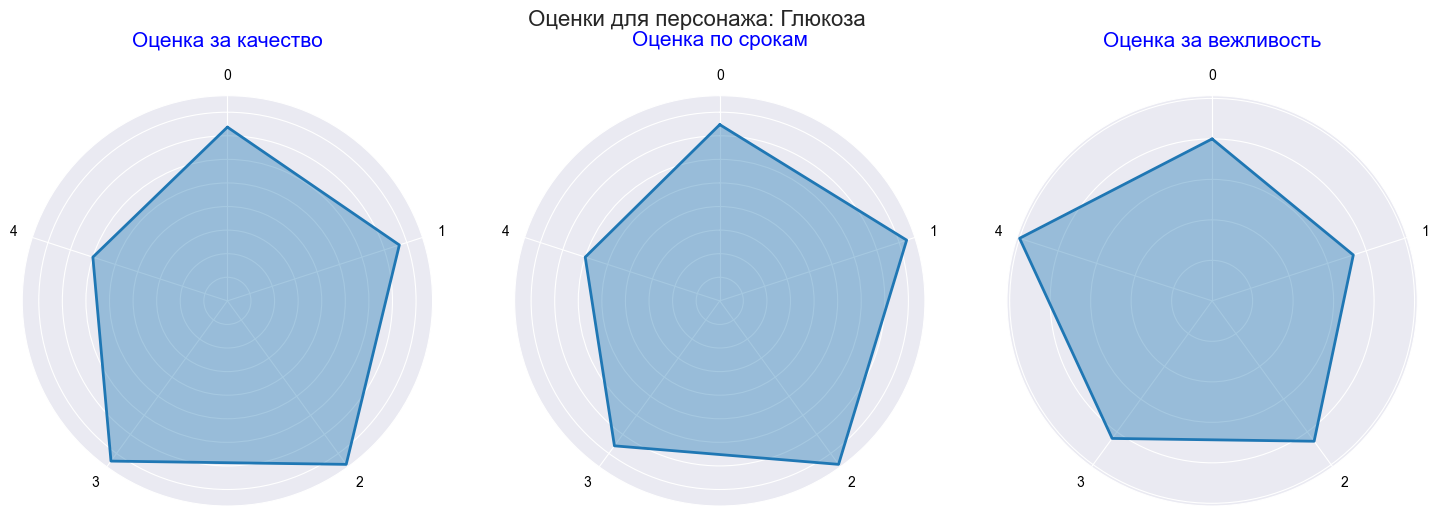

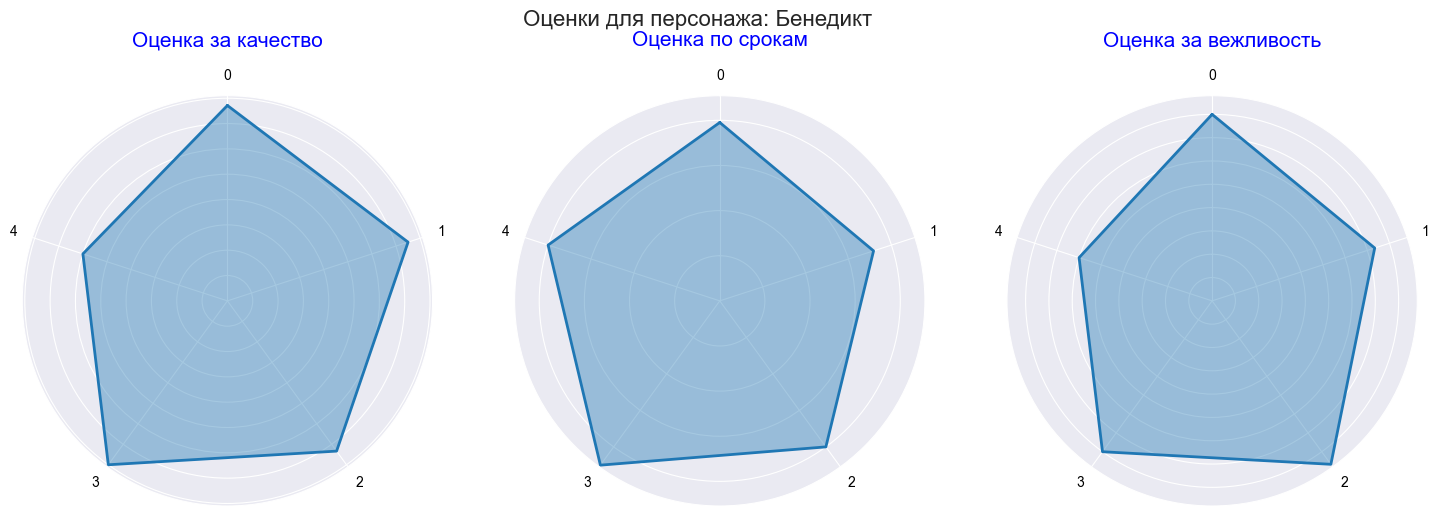

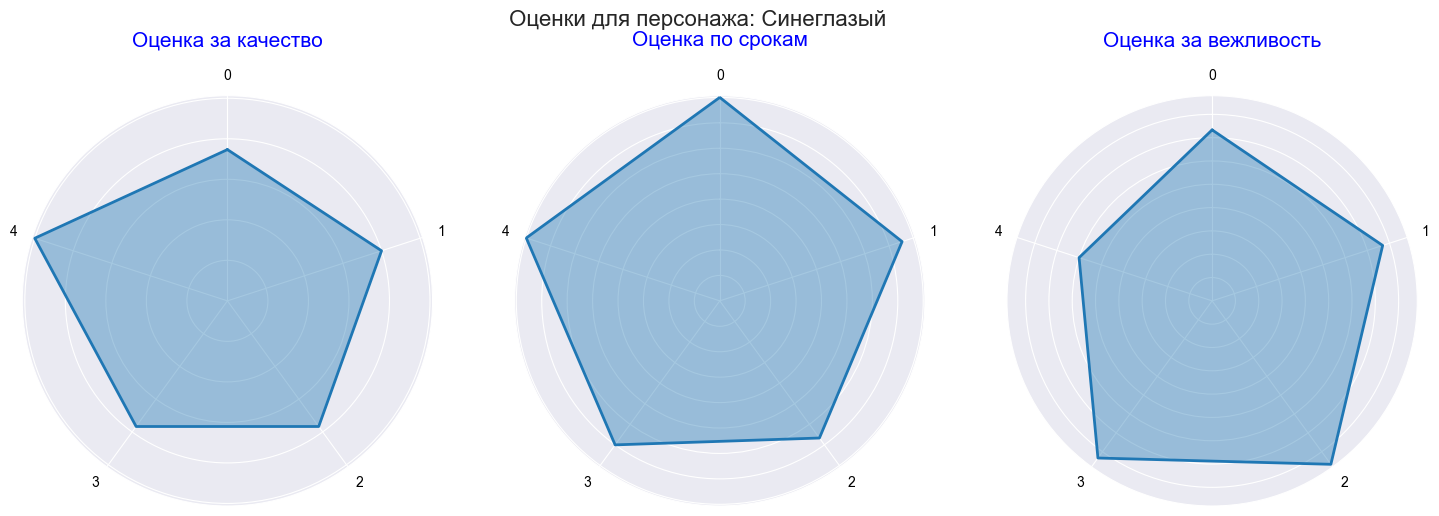

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Уникальные герои и группы
heroes = all_data['Герой'].unique()
groups = sorted(all_data['group'].unique())  # Упорядоченные значения для групп

# Группировка данных с агрегацией по средним для каждого критерия оценки
data = all_data.groupby(['Герой', 'group'])[['Оценка за качество', 'Оценка по срокам', 'Оценка за вежливость']].mean()

# Функция для построения радарной диаграммы
def plot_radar(hero_data, hero_name):
    criteria = ['Оценка за качество', 'Оценка по срокам', 'Оценка за вежливость']
    num_vars = len(groups)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Замкнуть круг

    fig, axes = plt.subplots(1, 3, subplot_kw=dict(polar=True), figsize=(18, 6))
    fig.suptitle(f'Оценки для персонажа: {hero_name}', fontsize=16)
    
    for i, criterion in enumerate(criteria):
        # Получение среднего значения для текущего критерия и замыкание данных
        values = hero_data[criterion].reindex(groups).fillna(0).tolist()
        values += values[:1]  # Замкнуть круг
        
        ax = axes[i]
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        # Построение графика с подписями для групп
        ax.plot(angles, values, linewidth=2, linestyle='solid')
        ax.fill(angles, values, alpha=0.4)
        ax.set_yticklabels([])  # Убираем подписи осей
        ax.set_xticks(angles[:-1])  # Устанавливаем подписи только по углам (без дублирующего угла)
        ax.set_xticklabels(groups, size=10, color='black')  # Подписи углов значениями group
        ax.set_title(criterion, size=15, color='blue', y=1.1)

    plt.show()

# Построение диаграмм для каждого героя
for hero in heroes:
    hero_data = data.loc[hero] if hero in data.index else None
    if hero_data is not None:
        plot_radar(hero_data, hero)


# Проверка влияния факторов на оценку за задание

<Axes: >

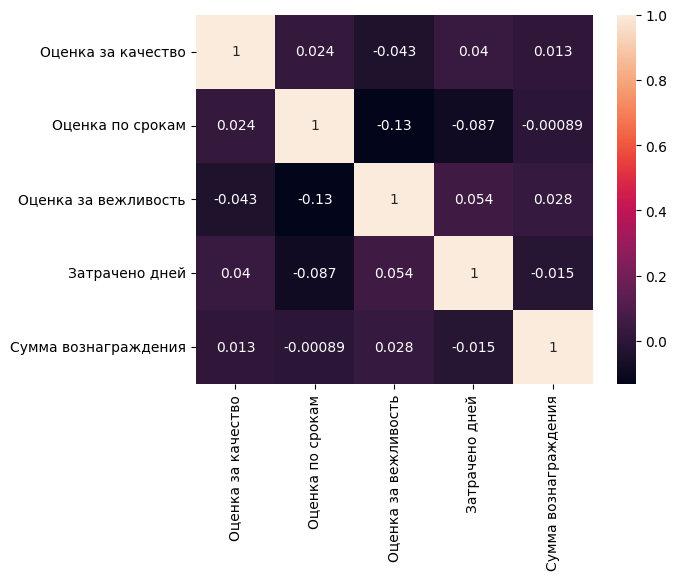

In [165]:
import pandas as pd

# Выборка нужных столбцов
data = all_data[['Оценка за качество', 'Оценка по срокам', 'Оценка за вежливость', 'Затрачено дней', 'Сумма вознаграждения']]

# Рассчёт корреляционной матрицы
correlation_matrix = data.corr()
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True)

In [ ]:

# import statsmodels.api as sm

# # Выбор независимых переменных
# X = all_data[all_data['Выполнено']=='да'][['Затрачено дней', 'Сумма вознаграждения']]
# X = sm.add_constant(X)  # Добавляем константу для свободного члена

# # Целевая переменная
# y = all_data[all_data['Выполнено']=='да']['Оценка за качество']

# # Сброс индексов для выравнивания
# X = X.reset_index(drop=True)
# y = y.reset_index(drop=True)

# # Построение модели
# model = sm.OLS(y, X).fit()
# print(model.summary())


import statsmodels.api as sm

# Выбор зависимых и независимых переменных
X = all_data[all_data['Выполнено']=='да'][['Затрачено дней', 'Сумма вознаграждения']]
X = sm.add_constant(X)  # Добавляем константу для свободного члена

# Модели для каждой из оценок
for target in ['Оценка за качество', 'Оценка по срокам', 'Оценка за вежливость']:
    y = all_data[all_data['Выполнено']=='да'][target]
    model = sm.OLS(y, X).fit()
    print(f"Regression results for {target}:")
    print(model.summary())
    print("\n")
    

Regression results for Оценка за качество:
                            OLS Regression Results                            
Dep. Variable:     Оценка за качество   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4453
Date:                Tue, 12 Nov 2024   Prob (F-statistic):              0.641
Time:                        12:53:07   Log-Likelihood:                -556.32
No. Observations:                 481   AIC:                             1119.
Df Residuals:                     478   BIC:                             1131.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [177]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Формула модели: зависимые переменные от независимых
model_formula = 'Q("Оценка по срокам") ~ Q("Затрачено дней") + Q("Сумма вознаграждения")'
anova_model = ols(model_formula, data=all_data[all_data['Выполнено']=='да']).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

                               sum_sq     df         F    PR(>F)
Q("Затрачено дней")          2.295460    1.0  3.644894  0.056840
Q("Сумма вознаграждения")    0.031274    1.0  0.049659  0.823752
Residual                   301.032048  478.0       NaN       NaN


В данной задаче не выявлено влияния факторов на оценку, следовательно гипотеза о том, что чем выше вознаграждение, тем выше сложность и тем больше нужно человек для выполнения отвергается. 
Однако в последнем тесте зависимость близка к уровню значимости 0.05, оценка по срокам зависит (с уверенностью меньше 95%) от затраченных дней
- Есть смысл оптимизировать, но неизвестно по какому параметру, так как от суммы вознаграждения не зависит, а количество дней известно постфактум
- К тому же нет прецендентов когда задачу выполняли два и более героев.

В связи с этим критерием для выбора количества героев будет только заполнение необходимых навыков для задания.

# Подготовка для рек системы

In [1]:
import pandas as pd

# Создание пустого датафрейма с нужными столбцами
columns = [
    "Номер поручения", 
    "Заказчик", 
    "Дата поручения", 
    "Предполагаемая дата выполнения", 
    "Затрачено дней", 
    "Сумма вознаграждения", 
    "Исполнитель", 
    "group"
]
tasks_table = pd.DataFrame(columns=columns)

# Фильтрация данных из all_data
filtered_data = all_data[all_data['Выполнено'] != 'да']

# Заполнение пустой таблицы значениями из отфильтрованных данных
tasks_table[['Номер поручения', 'Заказчик', 'Дата поручения', 'Сумма вознаграждения','group']] = \
    filtered_data[['Номер поручения', 'Заказчик', 'Дата поручения', 'Сумма вознаграждения']]

from datetime import datetime

# Функция для безопасного преобразования дат
def safe_parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except ValueError:
        return None  

# Применение функции к столбцу 'Дата поручения'
tasks_table['Дата поручения'] = tasks_table['Дата поручения'].apply(safe_parse_date)
# Теперь можно сортировать даты, игнорируя строки со значением None
tasks_table = tasks_table.sort_values(by='Дата поручения').reset_index(drop=True)
# Просмотр результата
tasks_table


NameError: name 'all_data' is not defined

# Рек система!

In [232]:
import pandas as pd

# Функция для подбора кандидатов по задаче
def recommend_candidates(task_group, hero_data, final_table):
    # Определение целевых действий по группе задач
    group_actions = {
        0: ['разжечь костёр', 'залечить раны', 'выследить цель'],
        1: ['найти пропажу', 'отыскать заказчика'],
        2: ['выследить цель'],
        3: ['разжечь костёр', 'залечить раны'],
        4: ['разжечь костёр', 'выследить цель']
    }
    
    # Получение целевых действий для данной группы
    target_actions = group_actions.get(task_group, [])

    # Фильтрация героев, которые обладают нужными навыками
    relevant_heroes = final_table[['Герой'] + target_actions].copy()

    # Подсчет средней оценки по целевым действиям для всех героев
    avg_action_scores = relevant_heroes[target_actions].mean()

    # Подсчет средней оценки по целевым действиям для каждого героя
    relevant_heroes['Skill Score'] = relevant_heroes[target_actions].mean(axis=1)

    # Группировка данных `hero_data` для получения уникальных записей по каждому герою
    unique_hero_data = hero_data.groupby('Герой').agg({
        'Оценка за качество': 'mean',
        'Оценка по срокам': 'mean',
        'Оценка за вежливость': 'mean',
        'Затрачено дней': 'mean'
    }).reset_index()

    # Объединение с данными о героях по оценкам качества, срокам, вежливости и времени выполнения
    candidate_data = pd.merge(relevant_heroes, unique_hero_data, on='Герой')

    # Нормализация оценки по срокам (чем меньше значение, тем лучше)
    candidate_data['Normalized Time'] = 1 / (candidate_data['Затрачено дней'] + 1e-5)

    # Итоговый рейтинг, объединяющий все оценки (веса можно подкорректировать)
    candidate_data['Final Score'] = (
        candidate_data['Skill Score'] * 0.4 +  # Вес на навыки
        candidate_data['Оценка за качество'] * 0.2 +  # Вес на качество
        candidate_data['Оценка по срокам'] * 0.25 +  # Вес на оценку срок выполнения
        candidate_data['Оценка за вежливость'] * 0.05 +  # Вес на вежливость
        candidate_data['Normalized Time'] * 0.1  # Вес на время выполнения
    )

    # Сортировка по итоговому рейтингу в порядке убывания
    sorted_candidates = candidate_data.sort_values(by='Final Score', ascending=False)

    # Список для хранения окончательных рекомендаций
    recommended_candidates = sorted_candidates[['Герой', 'Final Score']].copy()

    # Добавление комбинаций героев для покрытия всех действий
    combinations = []
    added_combinations = set()  # Множество для хранения уникальных комбинаций героев
    used_heroes = set()  # Множество для героев, уже включенных в комбинации
    
    for _, hero in sorted_candidates.iterrows():
        # Проверка, покрывает ли герой все целевые действия
        covers_all_actions = all(hero[action] >= avg_action_scores[action] for action in target_actions)
        
        if covers_all_actions and hero['Герой'] not in used_heroes:
            # Если герой покрывает все действия, добавляем его как одиночного кандидата
            combinations.append({
                'Герой': hero['Герой'],
                'Final Score': hero['Final Score']
            })
            used_heroes.add(hero['Герой'])  # Добавляем героя в список использованных
        else:
            # Если герой не покрывает все действия, ищем дополнительного героя для покрытия недостающих
            for _, additional_hero in sorted_candidates.iterrows():
                if additional_hero['Герой'] != hero['Герой'] and additional_hero['Герой'] not in used_heroes:
                    # Создаем комбинацию имен героев в алфавитном порядке для уникальности
                    hero_pair = tuple(sorted([hero['Герой'], additional_hero['Герой']]))
                    
                    # Проверка на дублирование комбинации
                    if hero_pair not in added_combinations:
                        # Проверка, может ли второй герой дополнить недостающие навыки
                        covers_missing_actions = all(
                            (hero[action] >= avg_action_scores[action] or additional_hero[action] > 0)
                            for action in target_actions
                        )
                        
                        if covers_missing_actions:
                            # Если пара героев покрывает все действия, рассчитываем общий скор комбинации
                            combined_score = (hero['Final Score'] + additional_hero['Final Score']) / 2
                            combinations.append({
                                'Герой': f"{hero['Герой']} & {additional_hero['Герой']}",
                                'Final Score': combined_score
                            })
                            added_combinations.add(hero_pair)  # Добавляем комбинацию, чтобы не повторять
                            used_heroes.update([hero['Герой'], additional_hero['Герой']])  # Добавляем героев в использованные
                            break

    # Добавляем комбинации к индивидуальным рекомендациям
    combined_df = pd.DataFrame(combinations)
    full_recommendations = pd.concat([recommended_candidates, combined_df], ignore_index=True)

    # Сортируем итоговую таблицу по скору
    full_recommendations = full_recommendations.sort_values(by='Final Score', ascending=False).reset_index(drop=True)

    return full_recommendations

# Пример использования функции для задачи из группы "Зачистка" (группа 0)
task_group = 3
recommended_candidates = recommend_candidates(task_group, hero_data, final_table)
print(recommended_candidates)


                 Герой  Final Score
0             Бенедикт     3.446360
1             Бенедикт     3.446360
2                 Соня     2.685551
3    Соня & Синеглазый     2.672694
4           Синеглазый     2.659837
5    Синеглазый & Юлия     2.639828
6                 Юлия     2.619819
7               Бендер     2.547339
8             Пастушок     2.530013
9                Агата     2.466248
10       Юлия & Мартин     2.452383
11             Глюкоза     2.444517
12   Бендер & Фредерик     2.391994
13  Пастушок & Альфред     2.370428
14              Мартин     2.284946
15            Фредерик     2.236650
16             Альфред     2.210843
17            Леопольд     2.071076


## Рабочая рек система

In [428]:
import pandas as pd

# Функция для подбора кандидатов по задаче с учетом доступности героев
def recommend_candidates(task_group, hero_data, final_table, availability):
    # Определение целевых действий по группе задач
    group_actions = {
        0: ['разжечь костёр', 'залечить раны', 'выследить цель'],
        1: ['найти пропажу', 'отыскать заказчика'],
        2: ['выследить цель'],
        3: ['разжечь костёр', 'залечить раны'],
        4: ['разжечь костёр', 'выследить цель']
    }
    
    # Получение целевых действий для данной группы
    target_actions = group_actions.get(task_group, [])

    # Фильтрация героев по доступности
    available_heroes = availability[availability['Доступен'] == True]['Герой'].tolist()
    filtered_final_table = final_table[final_table['Герой'].isin(available_heroes)]

    # Фильтрация героев, которые обладают нужными навыками
    relevant_heroes = filtered_final_table[['Герой'] + target_actions].copy()

    # Подсчет средней оценки по целевым действиям для всех героев
    avg_action_scores = relevant_heroes[target_actions].mean()

    # Подсчет средней оценки по целевым действиям для каждого героя
    relevant_heroes['Skill Score'] = relevant_heroes[target_actions].mean(axis=1)

    # Группировка данных `hero_data` для получения уникальных записей по каждому герою
    unique_hero_data = hero_data.groupby('Герой').agg({
        'Оценка за качество': 'mean',
        'Оценка по срокам': 'mean',
        'Оценка за вежливость': 'mean',
        'Затрачено дней': 'mean'
    }).reset_index()

    # Объединение с данными о героях по оценкам качества, срокам, вежливости и времени выполнения
    candidate_data = pd.merge(relevant_heroes, unique_hero_data, on='Герой')

    # Нормализация оценки по срокам (чем меньше значение, тем лучше)
    candidate_data['Normalized Time'] = 1 / (candidate_data['Затрачено дней'] + 1e-5)

    # Итоговый рейтинг, объединяющий все оценки
    candidate_data['Final Score'] = (
        candidate_data['Skill Score'] *5 +  # Вес на навыки
        candidate_data['Оценка за качество'] * 2 +  # Вес на качество
        candidate_data['Оценка по срокам'] * 3 +  # Вес на оценку срок выполнения
        candidate_data['Оценка за вежливость'] * 1 +  # Вес на вежливость
        candidate_data['Normalized Time'] * 3  # Вес на время выполнения
    )

    # Сортировка по итоговому рейтингу в порядке убывания
    sorted_candidates = candidate_data.sort_values(by='Final Score', ascending=False)

    # Список для хранения окончательных рекомендаций
    recommended_candidates = sorted_candidates[['Герой', 'Final Score']].copy()

    # Добавление комбинаций героев для покрытия всех действий
    combinations = []
    added_combinations = set()  # Множество для хранения уникальных комбинаций героев
    used_heroes = set()  # Множество для героев, уже включенных в комбинации
    
    for _, hero in sorted_candidates.iterrows():
        # Проверка, покрывает ли герой все целевые действия
        covers_all_actions = all(hero[action] >= avg_action_scores[action] for action in target_actions)
        
        if covers_all_actions and hero['Герой'] not in used_heroes:
            # Если герой покрывает все действия, добавляем его как одиночного кандидата
            combinations.append({
                'Герой': hero['Герой'],
                'Final Score': hero['Final Score']
            })
            used_heroes.add(hero['Герой'])  # Добавляем героя в список использованных
        else:
            # Если герой не покрывает все действия, ищем дополнительного героя для покрытия недостающих
            for _, additional_hero in sorted_candidates.iterrows():
                if additional_hero['Герой'] != hero['Герой'] and additional_hero['Герой'] not in used_heroes:
                    # Создаем комбинацию имен героев в алфавитном порядке для уникальности
                    hero_pair = tuple(sorted([hero['Герой'], additional_hero['Герой']]))
                    
                    # Проверка на дублирование комбинации
                    if hero_pair not in added_combinations:
                        # Проверка, может ли второй герой дополнить недостающие навыки
                        covers_missing_actions = all(
                            (hero[action] >= avg_action_scores[action] or additional_hero[action] > 0)
                            for action in target_actions
                        )
                        
                        if covers_missing_actions:
                            # Если пара героев покрывает все действия, рассчитываем общий скор комбинации
                            combined_score = (hero['Final Score'] + additional_hero['Final Score']) / 2
                            combinations.append({
                                'Герой': f"{hero['Герой']} & {additional_hero['Герой']}",
                                'Final Score': combined_score
                            })
                            added_combinations.add(hero_pair)  # Добавляем комбинацию, чтобы не повторять
                            used_heroes.update([hero['Герой'], additional_hero['Герой']])  # Добавляем героев в использованные
                            break

    # Добавляем комбинации к индивидуальным рекомендациям
    combined_df = pd.DataFrame(combinations)
    full_recommendations = pd.concat([recommended_candidates, combined_df], ignore_index=True)

    # Сортируем итоговую таблицу по скору
    full_recommendations = full_recommendations.sort_values(by='Final Score', ascending=False).reset_index(drop=True)
    full_recommendations = full_recommendations.drop_duplicates(subset=['Герой'], keep='first')
    return full_recommendations

# Пример таблицы доступности героев
availability = pd.DataFrame({
    'Герой': [
        'Агата', 'Альфред', 'Бендер', 'Бенедикт', 'Глюкоза', 'Леопольд', 'Мартин',
        'Пастушок', 'Синеглазый', 'Соня', 'Фредерик', 'Юлия'
    ],
    'Доступен': [True, True, True, True, True, True, True, True, True, True, True, True]
})

# Пример использования функции для задачи из группы "Зачистка" (группа 3)
task_group = 1
recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability)
print(recommended_candidates)


                  Герой  Final Score
0                 Агата    48.808944
2               Альфред    48.343204
4                Мартин    39.204103
6                  Соня    39.167690
8               Глюкоза    38.927369
10             Леопольд    38.886084
12             Бенедикт    38.839612
14           Синеглазый    38.831533
16                 Юлия    38.396347
18               Бендер    29.924286
19    Бендер & Пастушок    29.838806
20             Пастушок    29.753327
21  Пастушок & Фредерик    29.247246
22             Фредерик    28.741166


In [429]:
final_table

,Герой,выследить цель,залечить раны,найти пропажу,отыскать заказчика,разжечь костёр,Роль (разжечь костёр)
0,Агата,5.0,0.0,5.0,5.0,2.5,лучник
1,Альфред,5.0,1.0,5.0,5.0,0.5,рейнджер
2,Бендер,1.0,0.0,1.0,1.0,2.5,мечник
3,Бенедикт,3.0,5.0,3.0,3.0,2.5,рейнджер
4,Глюкоза,3.0,0.0,3.0,3.0,2.5,боевой маг
5,Леопольд,3.0,0.0,3.0,3.0,0.5,мечник
6,Мартин,3.0,1.0,3.0,3.0,0.5,лучник
7,Пастушок,1.0,0.0,1.0,1.0,2.5,мечник
8,Синеглазый,3.0,1.0,3.0,3.0,2.5,рейнджер
9,Соня,3.0,3.0,3.0,3.0,0.5,боевой маг


In [ ]:
import pandas as pd

# Функция для подбора кандидатов по задаче
def recommend_candidates(task_group, hero_data, final_table):
    # Определение целевых действий по группе задач
    group_actions = {
        0: ['разжечь костёр', 'залечить раны', 'выследить цель'],
        1: ['найти пропажу', 'отыскать заказчика'],
        2: ['выследить цель'],
        3: ['разжечь костёр', 'залечить раны'],
        4: ['разжечь костёр', 'выследить цель']
    }
    
    # Получение целевых действий для данной группы
    target_actions = group_actions.get(task_group, [])

    # Фильтрация героев, которые обладают нужными навыками
    relevant_heroes = final_table[['Герой'] + target_actions].copy()

    # Подсчет средней оценки по целевым действиям для всех героев
    avg_action_scores = relevant_heroes[target_actions].mean()

    # Подсчет средней оценки по целевым действиям для каждого героя
    relevant_heroes['Skill Score'] = relevant_heroes[target_actions].mean(axis=1)

    # Фильтрация `hero_data` по группе задач `task_group`
    filtered_hero_data = hero_data[hero_data['group'] == task_group]

    # Группировка данных `filtered_hero_data` для получения уникальных записей по каждому герою для заданной группы
    unique_hero_data = filtered_hero_data.groupby('Герой').agg({
        'Оценка за качество': 'mean',
        'Оценка по срокам': 'mean',
        'Оценка за вежливость': 'mean',
        'Затрачено дней': 'mean'
    }).reset_index()

    # Объединение с данными о героях по оценкам качества, срокам, вежливости и времени выполнения
    candidate_data = pd.merge(relevant_heroes, unique_hero_data, on='Герой')

    # Нормализация оценки по срокам (чем меньше значение, тем лучше)
    candidate_data['Normalized Time'] = 1 / (candidate_data['Затрачено дней'] + 1e-5)

    # Итоговый рейтинг, объединяющий все оценки (веса можно подкорректировать)
    candidate_data['Final Score'] = (
        candidate_data['Skill Score'] * 0.4 +  # Вес на навыки
        candidate_data['Оценка за качество'] * 0.2 +  # Вес на качество
        candidate_data['Оценка по срокам'] * 0.25 +  # Вес на оценку срок выполнения
        candidate_data['Оценка за вежливость'] * 0.05 +  # Вес на вежливость
        candidate_data['Normalized Time'] * 0.1  # Вес на время выполнения
    )

    # Сортировка по итоговому рейтингу в порядке убывания
    sorted_candidates = candidate_data.sort_values(by='Final Score', ascending=False)

    # Список для хранения окончательных рекомендаций
    recommended_candidates = sorted_candidates[['Герой', 'Final Score']].copy()

    # Добавление комбинаций героев для покрытия всех действий
    combinations = []
    added_combinations = set()  # Множество для хранения уникальных комбинаций героев
    used_heroes = set()  # Множество для героев, уже включенных в комбинации
    
    for _, hero in sorted_candidates.iterrows():
        # Проверка, покрывает ли герой все целевые действия
        covers_all_actions = all(hero[action] >= avg_action_scores[action] for action in target_actions)
        
        if covers_all_actions and hero['Герой'] not in used_heroes:
            # Если герой покрывает все действия, добавляем его как одиночного кандидата
            combinations.append({
                'Герой': hero['Герой'],
                'Final Score': hero['Final Score']
            })
            used_heroes.add(hero['Герой'])  # Добавляем героя в список использованных
        else:
            # Если герой не покрывает все действия, ищем дополнительного героя для покрытия недостающих
            for _, additional_hero in sorted_candidates.iterrows():
                if additional_hero['Герой'] != hero['Герой'] and additional_hero['Герой'] not in used_heroes:
                    # Создаем комбинацию имен героев в алфавитном порядке для уникальности
                    hero_pair = tuple(sorted([hero['Герой'], additional_hero['Герой']]))
                    
                    # Проверка на дублирование комбинации
                    if hero_pair not in added_combinations:
                        # Проверка, может ли второй герой дополнить недостающие навыки
                        covers_missing_actions = all(
                            (hero[action] >= avg_action_scores[action] or additional_hero[action] > 0)
                            for action in target_actions
                        )
                        
                        if covers_missing_actions:
                            # Если пара героев покрывает все действия, рассчитываем общий скор комбинации
                            combined_score = (hero['Final Score'] + additional_hero['Final Score']) / 2
                            combinations.append({
                                'Герой': f"{hero['Герой']} & {additional_hero['Герой']}",
                                'Final Score': combined_score
                            })
                            added_combinations.add(hero_pair)  # Добавляем комбинацию, чтобы не повторять
                            used_heroes.update([hero['Герой'], additional_hero['Герой']])  # Добавляем героев в использованные
                            break

    # Добавляем комбинации к индивидуальным рекомендациям
    combined_df = pd.DataFrame(combinations)
    full_recommendations = pd.concat([recommended_candidates, combined_df], ignore_index=True)

    # Сортируем итоговую таблицу по скору
    full_recommendations = full_recommendations.sort_values(by='Final Score', ascending=False).reset_index(drop=True)

    return full_recommendations

# Пример использования функции для задачи из группы "Зачистка" (группа 3)
task_group = 3
recommended_candidates = recommend_candidates(task_group, hero_data, final_table)
print(recommended_candidates) 


                  Герой  Final Score
0              Бенедикт     9.665000
1              Бенедикт     9.665000
2                  Соня     5.549160
3           Соня & Юлия     5.463580
4                  Юлия     5.378000
5     Юлия & Синеглазый     5.373375
6            Синеглазый     5.368750
7                 Агата     4.813333
8               Глюкоза     4.526316
9              Пастушок     4.523077
10  Синеглазый & Мартин     4.516782
11               Бендер     4.494048
12      Агата & Альфред     4.190877
13   Глюкоза & Фредерик     3.937423
14               Мартин     3.664815
15              Альфред     3.568421
16             Фредерик     3.348529
17             Леопольд     2.569231


# Прогностическая модель

In [309]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Подготовка данных
X = all_data[all_data['Выполнено']=='да'][['Герой', 'group', 'Оценка по срокам']]
y = all_data[all_data['Выполнено']=='да']['Затрачено дней']

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Категориальные и числовые признаки
categorical_features = ['Герой', 'group', 'Оценка по срокам']

# Препроцессор для категориальных и числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Создание пайплайнов для разных регрессионных моделей
regressors = {
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ]),
    'KNeighbors': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor())
    ])
}

# Обучение и оценка регрессионных моделей
for model_name, model_pipeline in regressors.items():
    # Обучение модели
    model_pipeline.fit(X_train, y_train)
    
    # Предсказание на тестовом наборе
    y_pred = model_pipeline.predict(X_test)
    
    # Округление предсказаний до ближайшего целого
    y_pred_rounded = np.round(y_pred).astype(int)
    
    # Оценка модели
    mae = mean_absolute_error(y_test, y_pred_rounded)
    r2 = r2_score(y_test, y_pred_rounded)
    print(f"Модель: {model_name}")
    print(f"Средняя абсолютная ошибка: {mae:.2f}")
    print(f"Коэффициент детерминации R^2: {r2:.2f}")
    print("-" * 40)


Модель: RandomForest
Средняя абсолютная ошибка: 2.71
Коэффициент детерминации R^2: -0.18
----------------------------------------
Модель: GradientBoosting
Средняя абсолютная ошибка: 2.64
Коэффициент детерминации R^2: -0.10
----------------------------------------
Модель: KNeighbors
Средняя абсолютная ошибка: 2.56
Коэффициент детерминации R^2: -0.09
----------------------------------------


Выберем модель KNN, так как у неё лучший скор

In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Подготовка данных
X = all_data[all_data['Выполнено'] == 'да'][['Герой', 'group', 'Сумма вознаграждения', 'Оценка по срокам']]
y = all_data[all_data['Выполнено'] == 'да']['Затрачено дней']

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Категориальные и числовые признаки
categorical_features = ['Герой', 'group', 'Оценка по срокам']

# Кодирование категориальных переменных и нормализация числовых
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

# Функция для оптимизации гиперпараметров модели KNN
def objective(trial):
    # Гиперпараметры для настройки
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)  # Метрика расстояния: Манхэттенская (p=1) или Евклидова (p=2)
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    # Создание пайплайна с KNN
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('knn', KNeighborsRegressor(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p,
            algorithm=algorithm
        ))
    ])

    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test)
    y_pred_rounded = np.round(y_pred).astype(int)  # Округление до целых значений
    
    # Оценка модели
    mse = mean_squared_error(y_test, y_pred_rounded)
    return mse

# Оптимизация гиперпараметров с помощью Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Число проб можно увеличить для более точной оптимизации

# Лучшие гиперпараметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение модели с лучшими параметрами
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(
        n_neighbors=best_params['n_neighbors'],
        weights=best_params['weights'],
        p=best_params['p'],
        algorithm=best_params['algorithm']
    ))
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)

# Оценка модели
mse = mean_squared_error(y_test, y_pred_rounded)
mae = mean_absolute_error(y_test, y_pred_rounded)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")




In [307]:
# Таблица для визуального сравнения
comparison_df = pd.DataFrame({
    'True Duration (y_test)': y_test,
    'Predicted Duration (y_pred_rounded)': y_pred_rounded
})

comparison_df

,True Duration (y_test),Predicted Duration (y_pred_rounded)
74,10.0,5
432,9.0,6
407,7.0,5
286,8.0,5
415,6.0,5
...,...,...
245,2.0,6
425,1.0,6
25,1.0,4
272,7.0,5


Нормально, но сравним с обычным усреднением 

In [319]:
# Объединяем X и y для упрощения работы
data = pd.concat([X, y], axis=1)

# Группировка по сочетаниям 'Герой' и 'group' и вычисление среднего значения 'Затрачено дней'
average_duration = data.groupby(['Герой', 'group'])['Затрачено дней'].mean().reset_index()

# Создаем словарь с средними значениями для каждой комбинации (Герой, group)
average_dict = dict(zip(zip(average_duration['Герой'], average_duration['group']), average_duration['Затрачено дней']))

# Преобразование X_test обратно, чтобы использовать те же значения для получения среднего
X_test_combined = list(zip(X_test['Герой'], X_test['group']))

# Предсказания на основе среднего
y_pred_mean = [average_dict.get(item, None) for item in X_test_combined]
y_pred_mean=np.round(y_pred_mean)

In [321]:
# Преобразуем y_pred_mean в DataFrame для удобства сравнения
comparison_df = pd.DataFrame({
    'y_test': y_test.values,
    'y_pred_knn': y_pred_rounded,
    'y_pred_mean': y_pred_mean
})

# Рассчитываем ошибки (например, MSE) для обеих моделей
mse_knn = mean_squared_error(y_test, y_pred_rounded)
mse_mean = mean_squared_error(y_test, y_pred_mean)

# Выводим результаты
print(f"MSE KNN: {mse_knn}")
print(f"MSE по среднему: {mse_mean}")

# Сравниваем результаты
comparison_df


MSE KNN: 7.77319587628866
MSE по среднему: 7.164948453608248


,y_test,y_pred_knn,y_pred_mean
0,10.0,4,5.0
1,9.0,6,5.0
2,7.0,5,5.0
3,8.0,5,5.0
4,6.0,6,5.0
...,...,...,...
92,2.0,6,4.0
93,1.0,5,5.0
94,1.0,4,5.0
95,7.0,5,5.0


Удивительно, но факт. Простые модели нельзя обходить. В этом случае обычное среднее по группе и герою дало лучший результат по сравнению со всякими мл модельками. Поэтому не будем заморачиваться и будем делать предсказания по среднему. 

In [325]:
# Подготовка данных: фильтрация по выполненным заданиям
X = all_data[all_data['Выполнено'] == 'да'][['Герой', 'group']]
y = all_data[all_data['Выполнено'] == 'да']['Затрачено дней']

# Объединяем X и y для упрощения работы
data = pd.concat([X, y], axis=1)

# Группировка по сочетаниям 'Герой' и 'group' и вычисление среднего значения 'Затрачено дней'
average_duration = data.groupby(['Герой', 'group'])['Затрачено дней'].mean().reset_index()
average_duration=np.round(average_duration)


# Полный алгоритм рекомендации

In [375]:
tasks_table['Сдвинутая дата поручения']= pd.Series([None]*len(tasks_table))

In [ ]:
tasks_table= tasks_table.merge(all_data[['Номер поручения','group']],on='Номер поручения')
tasks_table

In [ ]:
import pandas as pd
from datetime import timedelta

# Основной алгоритм последовательного выполнения задач
def assign_tasks(tasks_table, availability, average_duration, hero_data, final_table):
    # Перебираем каждую задачу в таблице задач
    for index, task in tasks_table.iterrows():
        task_group = task['group']
        task_date = task['Дата поручения']
        
        # Рекомендация исполнителя на основе функции recommend_candidates
        recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability)
        if recommended_candidates.empty:
            continue  # Пропуск, если нет подходящих кандидатов

        # Выбор исполнителя с наивысшим скором
        best_candidate = recommended_candidates.iloc[0]  # Берем героя с наибольшим скором
        hero_name = best_candidate['Герой']
        
        # Обновляем доступность в таблице availability
        availability.loc[availability['Герой'] == hero_name, 'Доступен'] = False

        # Прогноз времени выполнения по таблице average_duration
        hero_duration = average_duration[(average_duration['Герой'] == hero_name) & (average_duration['group'] == task_group)]
        if not hero_duration.empty:
            days_required = hero_duration['Затрачено дней'].values[0]
        else:
            days_required = 1  # Устанавливаем минимальное значение, если данные отсутствуют
        
        # Записываем прогнозируемое время в tasks_table
        tasks_table.at[index, 'Затрачено дней'] = days_required
        tasks_table.at[index, 'Исполнитель'] = hero_name

        # Рассчитываем и записываем предполагаемую дату выполнения
        estimated_end_date = task_date + timedelta(days=days_required)
        tasks_table.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

        # Обновляем доступность героев, проверяя все предполагаемые даты выполнения
        for hero in availability['Герой']:
            hero_tasks = tasks_table[(tasks_table['Исполнитель'] == hero) & (tasks_table['Предполагаемая дата выполнения'].notnull())]
            if not hero_tasks.empty:
                last_end_date = hero_tasks['Предполагаемая дата выполнения'].max()
                if last_end_date >= task_date:
                    availability.loc[availability['Герой'] == hero, 'Доступен'] = False
                else:
                    availability.loc[availability['Герой'] == hero, 'Доступен'] = True

        # Если все герои недоступны, переносим дату поручения
        if not availability['Доступен'].any():
            earliest_hero = availability.merge(tasks_table, left_on='Герой', right_on='Исполнитель')
            earliest_hero = earliest_hero.sort_values(by='Предполагаемая дата выполнения').iloc[0]
            tasks_table.at[index, 'Сдвинутая дата поручения'] = earliest_hero['Предполагаемая дата выполнения']

    return tasks_table

# Пример использования:
# Обновленная таблица задач с заполненными полями
tasks_table = assign_tasks(tasks_table, availability, average_duration, hero_data, final_table)
tasks_table


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Проверка и преобразование даты в нужный формат, если это строка
def convert_to_date(date):
    if isinstance(date, str):
        try:
            return datetime.strptime(date, '%d.%m.%Y')
        except ValueError:
            print(f"Некорректный формат даты: {date}")
            return None
    return date  # Если это уже datetime, возвращаем как есть

# Основной алгоритм последовательного выполнения задач
def assign_tasks(tasks_table, availability, average_duration, hero_data, final_table):
    # Сброс доступности для всех героев перед началом
    availability['Доступен'] = True
    
    for index, task in tasks_table.iterrows():
        task_group = task['group']
        task_date = convert_to_date(task['Дата поручения'])
        
        # Пропуск задачи, если дата некорректна
        if task_date is None:
            print(f"Некорректная дата поручения в строке {index}, пропуск задания.")
            continue

        # Рекомендация исполнителя на основе функции recommend_candidates
        recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability)
        if recommended_candidates.empty:
            print(f"Нет доступных кандидатов для задачи в строке {index}")
            continue

        # Выбор исполнителя с наивысшим скором
        best_candidate = recommended_candidates.iloc[0]
        hero_name = best_candidate['Герой']
        
        print(f"Выбран кандидат {hero_name} для задачи в строке {index}")
        
        # Обновляем доступность в таблице availability
        availability.loc[availability['Герой'] == hero_name, 'Доступен'] = False
        tasks_table.at[index, 'Исполнитель'] = hero_name

        # Получаем количество дней по таблице average_duration
        hero_duration = average_duration[(average_duration['Герой'] == hero_name) & (average_duration['group'] == task_group)]
        if not hero_duration.empty:
            days_required = hero_duration['Затрачено дней'].values[0]
        else:
            days_required = 1  # Устанавливаем минимальное значение, если данные отсутствуют

        # Записываем прогнозируемое время выполнения
        tasks_table.at[index, 'Затрачено дней'] = days_required
        estimated_end_date = task_date + timedelta(days=days_required)
        tasks_table.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

        # Проверка доступности героев на основе даты
        for hero in availability['Герой']:
            hero_tasks = tasks_table[(tasks_table['Исполнитель'] == hero) & (tasks_table['Предполагаемая дата выполнения'].notnull())]
            if not hero_tasks.empty:
                last_end_date = hero_tasks['Предполагаемая дата выполнения'].max()
                if last_end_date >= task_date:
                    availability.loc[availability['Герой'] == hero, 'Доступен'] = False
                else:
                    availability.loc[availability['Герой'] == hero, 'Доступен'] = True

    return tasks_table

# Пример использования:
# После выполнения таблица задач tasks_table будет содержать заполненные данные
tasks_table['Дата поручения'] = tasks_table['Дата поручения'].apply(convert_to_date)
tasks_table = assign_tasks(tasks_table, availability, average_duration, hero_data, final_table)
tasks_table


уже лучше но доступность сломалась

In [412]:
import pandas as pd
from datetime import datetime, timedelta

# Проверка и преобразование даты в нужный формат, если это строка
def convert_to_date(date):
    if isinstance(date, str):
        try:
            return datetime.strptime(date, '%d.%m.%Y')
        except ValueError:
            print(f"Некорректный формат даты: {date}")
            return None
    return date  # Если это уже datetime, возвращаем как есть

# Основной алгоритм последовательного выполнения задач
def assign_tasks(tasks_table, availability, average_duration, hero_data, final_table):
    # Перебираем каждую задачу в таблице задач
    for index, task in tasks_table.iterrows():
        task_group = task['group']
        task_date = convert_to_date(task['Дата поручения'])
        
        # Пропуск задачи, если дата некорректна
        if task_date is None:
            print(f"Некорректная дата поручения в строке {index}, пропуск задания.")
            continue

        # Сброс доступности для всех героев перед выбором кандидата
        availability['Доступен'] = True

        # Рекомендация исполнителя на основе функции recommend_candidates
        recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability)
        if recommended_candidates.empty:
            print(f"Нет доступных кандидатов для задачи в строке {index}")
            continue

        # Выбор исполнителя с наивысшим скором
        best_candidate = recommended_candidates.iloc[0]
        hero_name = best_candidate['Герой']
        
        print(f"Выбран кандидат {hero_name} для задачи в строке {index}")
        
        # Обновляем доступность выбранного героя в таблице availability
        availability.loc[availability['Герой'] == hero_name, 'Доступен'] = False
        tasks_table.at[index, 'Исполнитель'] = hero_name

        # Получаем количество дней по таблице average_duration
        hero_duration = average_duration[(average_duration['Герой'] == hero_name) & (average_duration['group'] == task_group)]
        if not hero_duration.empty:
            days_required = hero_duration['Затрачено дней'].values[0]
        else:
            days_required = 1  # Устанавливаем минимальное значение, если данные отсутствуют

        # Записываем прогнозируемое время выполнения
        tasks_table.at[index, 'Затрачено дней'] = days_required
        estimated_end_date = task_date + timedelta(days=days_required)
        tasks_table.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

        # Проверка доступности героев на основе их предполагаемой даты выполнения
        for hero in availability['Герой']:
            hero_tasks = tasks_table[(tasks_table['Исполнитель'] == hero) & (tasks_table['Предполагаемая дата выполнения'].notnull())]
            if not hero_tasks.empty:
                last_end_date = hero_tasks['Предполагаемая дата выполнения'].max()
                # Герой доступен, если его последняя дата выполнения не пересекается с новой датой поручения
                availability.loc[availability['Герой'] == hero, 'Доступен'] = last_end_date < task_date

    return tasks_table

# Пример использования:
tasks_table['Дата поручения'] = tasks_table['Дата поручения'].apply(convert_to_date)
tasks_table = assign_tasks(tasks_table, availability, average_duration, hero_data, final_table)
tasks_table


Выбран кандидат Бенедикт для задачи в строке 0
Выбран кандидат Агата для задачи в строке 1
Выбран кандидат Бенедикт для задачи в строке 2
Выбран кандидат Агата для задачи в строке 3
Выбран кандидат Агата для задачи в строке 4
Выбран кандидат Агата для задачи в строке 5
Выбран кандидат Агата для задачи в строке 6
Выбран кандидат Агата для задачи в строке 7
Выбран кандидат Агата для задачи в строке 8
Выбран кандидат Агата для задачи в строке 9
Выбран кандидат Бенедикт для задачи в строке 10
Выбран кандидат Агата для задачи в строке 11
Выбран кандидат Бенедикт для задачи в строке 12
Выбран кандидат Бенедикт для задачи в строке 13
Выбран кандидат Бенедикт для задачи в строке 14
Выбран кандидат Агата для задачи в строке 15
Выбран кандидат Агата для задачи в строке 16
Выбран кандидат Агата для задачи в строке 17
Выбран кандидат Агата для задачи в строке 18


,Номер поручения,Заказчик,Дата поручения,Предполагаемая дата выполнения,Затрачено дней,Сумма вознаграждения,Исполнитель,Сдвинутая дата поручения,group
0,11134,Иван,1053-09-04 00:00:00,1053-09-09 00:00:00,5.0,27500,Бенедикт,NaN,0
1,11056,Мария,1053-09-06 00:00:00,1053-09-12 00:00:00,6.0,23500,Агата,NaN,1
2,11381,Егор,1053-09-20 00:00:00,1053-09-25 00:00:00,5.0,7000,Бенедикт,NaN,0
3,11311,Бабушка Синь,1053-09-20 00:00:00,1053-09-26 00:00:00,6.0,19000,Агата,NaN,1
4,11417,Леонтия,1053-09-22 00:00:00,1053-09-28 00:00:00,6.0,20500,Агата,NaN,1
5,11310,Надя,1053-09-24 00:00:00,1053-09-30 00:00:00,6.0,5000,Агата,NaN,2
6,11285,Чарли,1053-09-30 00:00:00,1053-10-06 00:00:00,6.0,5000,Агата,NaN,1
7,11218,Олег,1053-10-01 00:00:00,1053-10-07 00:00:00,6.0,16000,Агата,NaN,2
8,11161,Эмилио,1053-10-03 00:00:00,1053-10-09 00:00:00,6.0,7500,Агата,NaN,1
9,11387,Татьяна,1053-10-13 00:00:00,1053-10-19 00:00:00,6.0,6500,Агата,NaN,1


Рабочая!

In [426]:
import pandas as pd
from datetime import datetime, timedelta
availability['Доступен'] = True
# Проверка и преобразование даты в нужный формат, если это строка
def convert_to_date(date):
    if isinstance(date, str):
        try:
            return datetime.strptime(date, '%d.%m.%Y')
        except ValueError:
            print(f"Некорректный формат даты: {date}")
            return None
    return date  # Если это уже datetime, возвращаем как есть

# Основной алгоритм последовательного выполнения задач
def assign_tasks(tasks_table, availability, average_duration, hero_data, final_table):
    # Перебираем каждую задачу в таблице задач
    for index, task in tasks_table.iterrows():
        task_group = task['group']
        task_date = convert_to_date(task['Дата поручения'])
        
        # Пропуск задачи, если дата некорректна
        if task_date is None:
            print(f"Некорректная дата поручения в строке {index}, пропуск задания.")
            continue

        # Сброс доступности для всех героев перед выбором кандидата
        for hero in availability['Герой']:
            hero_tasks = tasks_table[(tasks_table['Исполнитель'] == hero) & (tasks_table['Предполагаемая дата выполнения'].notnull())]
            if not hero_tasks.empty:
                # Если герой завершил предыдущую задачу до текущей даты поручения, он доступен
                last_end_date = hero_tasks['Предполагаемая дата выполнения'].max()
                availability.loc[availability['Герой'] == hero, 'Доступен'] = last_end_date < task_date
            else:
                # Если задач у героя не было, то он доступен
                availability.loc[availability['Герой'] == hero, 'Доступен'] = True

        # Рекомендация исполнителя на основе функции recommend_candidates
        recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability)
        if recommended_candidates.empty:
            print(f"Нет доступных кандидатов для задачи в строке {index}")
            continue

        # Выбор исполнителя с наивысшим скором
        best_candidate = recommended_candidates.iloc[0]
        hero_name = best_candidate['Герой']
        
        print(f"Выбран кандидат {hero_name} для задачи в строке {index}")
        
        # Обновляем доступность выбранного героя в таблице availability
        availability.loc[availability['Герой'] == hero_name, 'Доступен'] = False
        tasks_table.at[index, 'Исполнитель'] = hero_name

        # Получаем количество дней по таблице average_duration
        hero_duration = average_duration[(average_duration['Герой'] == hero_name) & (average_duration['group'] == task_group)]
        if not hero_duration.empty:
            days_required = hero_duration['Затрачено дней'].values[0]
        else:
            days_required = 1  # Устанавливаем минимальное значение, если данные отсутствуют

        # Записываем прогнозируемое время выполнения
        tasks_table.at[index, 'Затрачено дней'] = days_required
        estimated_end_date = task_date + timedelta(days=days_required)
        tasks_table.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

    return tasks_table

# Пример использования:
tasks_table['Дата поручения'] = tasks_table['Дата поручения'].apply(convert_to_date)
tasks_table = assign_tasks(tasks_table, availability, average_duration, hero_data, final_table)
tasks_table


Выбран кандидат Мартин для задачи в строке 0
Выбран кандидат Бендер для задачи в строке 1
Выбран кандидат Мартин для задачи в строке 2
Выбран кандидат Бендер для задачи в строке 3
Выбран кандидат Пастушок для задачи в строке 4
Выбран кандидат Фредерик для задачи в строке 5
Выбран кандидат Мартин для задачи в строке 6
Выбран кандидат Юлия для задачи в строке 7
Выбран кандидат Леопольд для задачи в строке 8
Выбран кандидат Мартин для задачи в строке 9
Выбран кандидат Юлия для задачи в строке 10
Выбран кандидат Мартин для задачи в строке 11
Выбран кандидат Юлия для задачи в строке 12
Выбран кандидат Юлия для задачи в строке 13
Выбран кандидат Синеглазый для задачи в строке 14
Выбран кандидат Мартин для задачи в строке 15
Выбран кандидат Альфред для задачи в строке 16
Выбран кандидат Мартин для задачи в строке 17
Выбран кандидат Альфред для задачи в строке 18


,Номер поручения,Заказчик,Дата поручения,Предполагаемая дата выполнения,Затрачено дней,Сумма вознаграждения,Исполнитель,Сдвинутая дата поручения,group
0,11134,Иван,1053-09-04 00:00:00,1053-09-09 00:00:00,5.0,27500,Мартин,NaN,0
1,11056,Мария,1053-09-06 00:00:00,1053-09-12 00:00:00,6.0,23500,Бендер,NaN,1
2,11381,Егор,1053-09-20 00:00:00,1053-09-25 00:00:00,5.0,7000,Мартин,NaN,0
3,11311,Бабушка Синь,1053-09-20 00:00:00,1053-09-26 00:00:00,6.0,19000,Бендер,NaN,1
4,11417,Леонтия,1053-09-22 00:00:00,1053-09-28 00:00:00,6.0,20500,Пастушок,NaN,1
5,11310,Надя,1053-09-24 00:00:00,1053-09-30 00:00:00,6.0,5000,Фредерик,NaN,2
6,11285,Чарли,1053-09-30 00:00:00,1053-10-05 00:00:00,5.0,5000,Мартин,NaN,1
7,11218,Олег,1053-10-01 00:00:00,1053-10-06 00:00:00,5.0,16000,Юлия,NaN,2
8,11161,Эмилио,1053-10-03 00:00:00,1053-10-09 00:00:00,6.0,7500,Леопольд,NaN,1
9,11387,Татьяна,1053-10-13 00:00:00,1053-10-18 00:00:00,5.0,6500,Мартин,NaN,1


тесты на скор


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
availability['Доступен'] = True
# Проверка и преобразование даты в нужный формат, если это строка
def convert_to_date(date):
    if isinstance(date, str):
        try:
            return datetime.strptime(date, '%d.%m.%Y')
        except ValueError:
            print(f"Некорректный формат даты: {date}")
            return None
    return date  # Если это уже datetime, возвращаем как есть

# Основной алгоритм последовательного выполнения задач
def assign_tasks(tasks_table, availability, average_duration, hero_data, final_table):
    # Перебираем каждую задачу в таблице задач
    for index, task in tasks_table.iterrows():
        task_group = task['group']
        task_date = convert_to_date(task['Дата поручения'])
        
        # Пропуск задачи, если дата некорректна
        if task_date is None:
            print(f"Некорректная дата поручения в строке {index}, пропуск задания.")
            continue

        # Сброс доступности для всех героев перед выбором кандидата
        for hero in availability['Герой']:
            hero_tasks = tasks_table[(tasks_table['Исполнитель'] == hero) & (tasks_table['Предполагаемая дата выполнения'].notnull())]
            if not hero_tasks.empty:
                # Если герой завершил предыдущую задачу до текущей даты поручения, он доступен
                last_end_date = hero_tasks['Предполагаемая дата выполнения'].max()
                availability.loc[availability['Герой'] == hero, 'Доступен'] = last_end_date < task_date
            else:
                # Если задач у героя не было, то он доступен
                availability.loc[availability['Герой'] == hero, 'Доступен'] = True

        # Рекомендация исполнителя на основе функции recommend_candidates
        recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability)

        # Выводим столбцы для диагностики
        print("Столбцы в recommended_candidates:")
        print(recommended_candidates.columns)

        if recommended_candidates.empty:
            print(f"Нет доступных кандидатов для задачи в строке {index}")
            continue

        # Выводим скоры кандидатов для диагностики
        print(f"Кандидаты для задачи {index} (группа {task_group}):")
        for _, candidate in recommended_candidates.iterrows():
            print(f"  {candidate['Герой']} - Final Score: {candidate.get('Final Score', 'Нет данных по скору')}")

        # Сортируем кандидатов по столбцу 'Final Score'
        recommended_candidates = recommended_candidates.sort_values(by='Final Score', ascending=False)

        # Выбор кандидата с наивысшим 'Final Score'
        best_candidate = recommended_candidates.iloc[0]
        hero_name = best_candidate['Герой']

        print(f"Выбран кандидат {hero_name} для задачи в строке {index}")
        
        # Обновляем доступность выбранного героя в таблице availability
        availability.loc[availability['Герой'] == hero_name, 'Доступен'] = False
        tasks_table.at[index, 'Исполнитель'] = hero_name

        # Получаем количество дней по таблице average_duration
        hero_duration = average_duration[(average_duration['Герой'] == hero_name) & (average_duration['group'] == task_group)]
        if not hero_duration.empty:
            days_required = hero_duration['Затрачено дней'].values[0]
        else:
            days_required = 1  # Устанавливаем минимальное значение, если данные отсутствуют

        # Записываем прогнозируемое время выполнения
        tasks_table.at[index, 'Затрачено дней'] = days_required
        estimated_end_date = task_date + timedelta(days=days_required)
        tasks_table.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

    return tasks_table

# Пример использования:
tasks_table['Дата поручения'] = tasks_table['Дата поручения'].apply(convert_to_date)
tasks_table = assign_tasks(tasks_table, availability, average_duration, hero_data, final_table)
tasks_table


## Ещё одна рабочая таблица

In [445]:
availability

,Герой,Доступен
0,Агата,False
1,Альфред,False
2,Бендер,True
3,Бенедикт,False
4,Глюкоза,False
5,Леопольд,False
6,Мартин,False
7,Пастушок,True
8,Синеглазый,False
9,Соня,False


In [427]:
import pandas as pd
from datetime import datetime, timedelta
availability['Доступен'] = True
# Проверка и преобразование даты в нужный формат, если это строка
def convert_to_date(date):
    if isinstance(date, str):
        try:
            return datetime.strptime(date, '%d.%m.%Y')
        except ValueError:
            print(f"Некорректный формат даты: {date}")
            return None
    return date  # Если это уже datetime, возвращаем как есть

# Основной алгоритм последовательного выполнения задач
def assign_tasks(tasks_table, availability, average_duration, hero_data, final_table):
    # Перебираем каждую задачу в таблице задач
    for index, task in tasks_table.iterrows():
        task_group = task['group']
        task_date = convert_to_date(task['Дата поручения'])
        
        # Пропуск задачи, если дата некорректна
        if task_date is None:
            print(f"Некорректная дата поручения в строке {index}, пропуск задания.")
            continue

        # Сброс доступности для всех героев перед выбором кандидата
        for hero in availability['Герой']:
            # Находим задачи, назначенные на героя, с учетом предполагаемой даты выполнения
            hero_tasks = tasks_table[(tasks_table['Исполнитель'] == hero) & (tasks_table['Предполагаемая дата выполнения'].notnull())]
            
            # Проверяем, есть ли у героя задачи с датой завершения до текущей даты поручения
            if not hero_tasks.empty:
                last_end_date = hero_tasks['Предполагаемая дата выполнения'].max()
                # Если дата завершения предыдущей задачи раньше текущей даты поручения, герой доступен
                availability.loc[availability['Герой'] == hero, 'Доступен'] = last_end_date < task_date
            else:
                # Если задач у героя не было, он доступен
                availability.loc[availability['Герой'] == hero, 'Доступен'] = True

        # Рекомендация исполнителя на основе функции recommend_candidates
        recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability)
        if recommended_candidates.empty:
            print(f"Нет доступных кандидатов для задачи в строке {index}")
            continue

        # Выбор исполнителя с наивысшим скором
        best_candidate = recommended_candidates.iloc[0]
        hero_name = best_candidate['Герой']
        
        print(f"Выбран кандидат {hero_name} для задачи в строке {index}")
        
        # Обновляем доступность выбранного героя в таблице availability
        availability.loc[availability['Герой'] == hero_name, 'Доступен'] = False
        tasks_table.at[index, 'Исполнитель'] = hero_name

        # Получаем количество дней по таблице average_duration
        hero_duration = average_duration[(average_duration['Герой'] == hero_name) & (average_duration['group'] == task_group)]
        if not hero_duration.empty:
            days_required = hero_duration['Затрачено дней'].values[0]
        else:
            days_required = 1  # Устанавливаем минимальное значение, если данные отсутствуют

        # Записываем прогнозируемое время выполнения
        tasks_table.at[index, 'Затрачено дней'] = days_required
        estimated_end_date = task_date + timedelta(days=days_required)
        tasks_table.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

    return tasks_table

# Пример использования:
tasks_table['Дата поручения'] = tasks_table['Дата поручения'].apply(convert_to_date)
tasks_table = assign_tasks(tasks_table, availability, average_duration, hero_data, final_table)
tasks_table


Выбран кандидат Бенедикт для задачи в строке 0
Выбран кандидат Агата для задачи в строке 1
Выбран кандидат Бенедикт для задачи в строке 2
Выбран кандидат Агата для задачи в строке 3
Выбран кандидат Соня для задачи в строке 4
Выбран кандидат Глюкоза для задачи в строке 5
Выбран кандидат Агата для задачи в строке 6
Выбран кандидат Соня для задачи в строке 7
Выбран кандидат Глюкоза для задачи в строке 8
Выбран кандидат Агата для задачи в строке 9
Выбран кандидат Бенедикт для задачи в строке 10
Выбран кандидат Агата для задачи в строке 11
Выбран кандидат Бенедикт для задачи в строке 12
Выбран кандидат Бенедикт для задачи в строке 13
Выбран кандидат Агата для задачи в строке 14
Выбран кандидат Агата для задачи в строке 15
Выбран кандидат Соня для задачи в строке 16
Выбран кандидат Агата для задачи в строке 17
Выбран кандидат Мартин для задачи в строке 18


,Номер поручения,Заказчик,Дата поручения,Предполагаемая дата выполнения,Затрачено дней,Сумма вознаграждения,Исполнитель,Сдвинутая дата поручения,group
0,11134,Иван,1053-09-04 00:00:00,1053-09-09 00:00:00,5.0,27500,Бенедикт,NaN,0
1,11056,Мария,1053-09-06 00:00:00,1053-09-12 00:00:00,6.0,23500,Агата,NaN,1
2,11381,Егор,1053-09-20 00:00:00,1053-09-25 00:00:00,5.0,7000,Бенедикт,NaN,0
3,11311,Бабушка Синь,1053-09-20 00:00:00,1053-09-26 00:00:00,6.0,19000,Агата,NaN,1
4,11417,Леонтия,1053-09-22 00:00:00,1053-09-28 00:00:00,6.0,20500,Соня,NaN,1
5,11310,Надя,1053-09-24 00:00:00,1053-09-29 00:00:00,5.0,5000,Глюкоза,NaN,2
6,11285,Чарли,1053-09-30 00:00:00,1053-10-06 00:00:00,6.0,5000,Агата,NaN,1
7,11218,Олег,1053-10-01 00:00:00,1053-10-04 00:00:00,3.0,16000,Соня,NaN,2
8,11161,Эмилио,1053-10-03 00:00:00,1053-10-08 00:00:00,5.0,7500,Глюкоза,NaN,1
9,11387,Татьяна,1053-10-13 00:00:00,1053-10-19 00:00:00,6.0,6500,Агата,NaN,1


## Улучщенная версия предложения кандидатов

#### Лучшая функция для подбора

In [558]:
# Функция для подбора кандидатов по задаче с учетом доступности героев
def recommend_candidates(task_group, hero_data, final_table, availability, task_date):
    # Определение целевых действий по группе задач
    group_actions = {
        0: ['разжечь костёр', 'залечить раны', 'выследить цель'],
        1: ['найти пропажу', 'отыскать заказчика'],
        2: ['выследить цель'],
        3: ['разжечь костёр', 'залечить раны'],
        4: ['разжечь костёр', 'выследить цель']
    }
    
    # Получение целевых действий для данной группы
    target_actions = group_actions.get(task_group, [])

    # Фильтрация героев по доступности на основе даты поручения
    available_heroes = availability[
        (availability['Доступен'].isnull()) | (availability['Доступен'] < task_date)
    ]['Герой'].tolist()
    
    # Фильтрация таблицы с героями по доступности
    filtered_final_table = final_table[final_table['Герой'].isin(available_heroes)]

    # Фильтрация героев, которые обладают нужными навыками
    relevant_heroes = filtered_final_table[['Герой'] + target_actions].copy()

    # Подсчет средней оценки по целевым действиям для всех героев
    avg_action_scores = relevant_heroes[target_actions].mean()

    # Подсчет средней оценки по целевым действиям для каждого героя
    relevant_heroes['Skill Score'] = relevant_heroes[target_actions].mean(axis=1)

    # Группировка данных `hero_data` для получения уникальных записей по каждому герою
    unique_hero_data = hero_data.groupby('Герой').agg({
        'Оценка за качество': 'mean',
        'Оценка по срокам': 'mean',
        'Оценка за вежливость': 'mean',
        'Затрачено дней': 'mean'
    }).reset_index()

    # Объединение с данными о героях по оценкам качества, срокам, вежливости и времени выполнения
    candidate_data = pd.merge(relevant_heroes, unique_hero_data, on='Герой')

    # Нормализация оценки по срокам (чем меньше значение, тем лучше)
    candidate_data['Normalized Time'] = 1 / (candidate_data['Затрачено дней'] + 1e-5)

    # Итоговый рейтинг, объединяющий все оценки
    candidate_data['Final Score'] = (
        candidate_data['Skill Score'] * 5 +  # Вес на навыки
        candidate_data['Оценка за качество'] * 2 +  # Вес на качество
        candidate_data['Оценка по срокам'] * 3 +  # Вес на оценку срока выполнения
        candidate_data['Оценка за вежливость'] * 1 +  # Вес на вежливость
        candidate_data['Normalized Time'] * 3  # Вес на время выполнения
    )

    # Сортировка по итоговому рейтингу в порядке убывания
    sorted_candidates = candidate_data.sort_values(by='Final Score', ascending=False)

    # Список для хранения окончательных рекомендаций
    recommended_candidates = sorted_candidates[['Герой', 'Final Score']].copy()

    # Добавление комбинаций героев для покрытия всех действий
    combinations = []
    added_combinations = set()  # Множество для хранения уникальных комбинаций героев
    used_heroes = set()  # Множество для героев, уже включенных в комбинации
    
    for _, hero in sorted_candidates.iterrows():
        # Проверка, покрывает ли герой все целевые действия
        covers_all_actions = all(hero[action] >= avg_action_scores[action] for action in target_actions)
        
        if covers_all_actions and hero['Герой'] not in used_heroes:
            # Если герой покрывает все действия, добавляем его как одиночного кандидата
            combinations.append({
                'Герой': hero['Герой'],
                'Final Score': hero['Final Score']
            })
            used_heroes.add(hero['Герой'])  # Добавляем героя в список использованных
        else:
            # Если герой не покрывает все действия, ищем дополнительного героя для покрытия недостающих
            for _, additional_hero in sorted_candidates.iterrows():
                if additional_hero['Герой'] != hero['Герой'] and additional_hero['Герой'] not in used_heroes:
                    # Создаем комбинацию имен героев в алфавитном порядке для уникальности
                    hero_pair = tuple(sorted([hero['Герой'], additional_hero['Герой']]))
                    
                    # Проверка на дублирование комбинации
                    if hero_pair not in added_combinations:
                        # Проверка, может ли второй герой дополнить недостающие навыки
                        covers_missing_actions = all(
                            (hero[action] >= avg_action_scores[action] or additional_hero[action] > 0)
                            for action in target_actions
                        )
                        
                        if covers_missing_actions:
                            # Если пара героев покрывает все действия, рассчитываем общий скор комбинации
                            combined_score = (hero['Final Score'] + additional_hero['Final Score']) / 2
                            combinations.append({
                                'Герой': f"{hero['Герой']} & {additional_hero['Герой']}",
                                'Final Score': combined_score
                            })
                            added_combinations.add(hero_pair)  # Добавляем комбинацию, чтобы не повторять
                            used_heroes.update([hero['Герой'], additional_hero['Герой']])  # Добавляем героев в использованные
                            break

    # Добавляем комбинации к индивидуальным рекомендациям
    combined_df = pd.DataFrame(combinations)
    full_recommendations = pd.concat([recommended_candidates, combined_df], ignore_index=True)

    # Сортируем итоговую таблицу по скору
    full_recommendations = full_recommendations.sort_values(by='Final Score', ascending=False).reset_index(drop=True)
    full_recommendations = full_recommendations.drop_duplicates(subset=['Герой'], keep='first')
    return full_recommendations


In [481]:
import pandas as pd
from datetime import datetime, timedelta

# Инициализация столбца 'Доступен' значением None
availability['Доступен'] = None

# Проверка и преобразование даты в нужный формат, если это строка
def convert_to_date(date):
    if isinstance(date, str):
        try:
            return datetime.strptime(date, '%d.%m.%Y')
        except ValueError:
            print(f"Некорректный формат даты: {date}")
            return None
    return date  # Если это уже datetime, возвращаем как есть

# Основной алгоритм последовательного выполнения задач
def assign_tasks(tasks_table, availability, average_duration, hero_data, final_table):
    # Перебираем каждую задачу в таблице задач
    for index, task in tasks_table.iterrows():
        task_group = task['group']
        task_date = convert_to_date(task['Дата поручения'])
        
        # Пропуск задачи, если дата некорректна
        if task_date is None:
            print(f"Некорректная дата поручения в строке {index}, пропуск задания.")
            continue

        # Сброс доступности для всех героев перед выбором кандидата
        for hero in availability['Герой']:
            # Находим задачи, назначенные на героя, с учетом предполагаемой даты выполнения
            hero_tasks = tasks_table[(tasks_table['Исполнитель'] == hero) & (tasks_table['Предполагаемая дата выполнения'].notnull())]
            
            # Проверяем, есть ли у героя задачи с датой завершения до текущей даты поручения
            if not hero_tasks.empty:
                last_end_date = hero_tasks['Предполагаемая дата выполнения'].max()
                # Если дата завершения предыдущей задачи раньше текущей даты поручения, герой доступен
                availability.loc[availability['Герой'] == hero, 'Доступен'] = last_end_date
            else:
                # Если задач у героя не было, он доступен с текущего момента
                availability.loc[availability['Герой'] == hero, 'Доступен'] = None

        # Рекомендация исполнителя на основе функции recommend_candidates
        recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability, task_date)
        if recommended_candidates.empty:
            print(f"Нет доступных кандидатов для задачи в строке {index}")
            continue

        # Выбор исполнителя с наивысшим скором
        best_candidate = recommended_candidates.iloc[0]
        hero_name = best_candidate['Герой']
        
        print(f"Выбран кандидат {hero_name} для задачи в строке {index}")
        
        # Обновляем доступность выбранного героя в таблице availability
        availability.loc[availability['Герой'] == hero_name, 'Доступен'] = task_date + timedelta(days=1)
        tasks_table.at[index, 'Исполнитель'] = hero_name

        # Получаем количество дней по таблице average_duration
        hero_duration = average_duration[(average_duration['Герой'] == hero_name) & (average_duration['group'] == task_group)]
        if not hero_duration.empty:
            days_required = hero_duration['Затрачено дней'].values[0]
        else:
            days_required = 1  # Устанавливаем минимальное значение, если данные отсутствуют

        # Записываем прогнозируемое время выполнения
        tasks_table.at[index, 'Затрачено дней'] = days_required
        estimated_end_date = task_date + timedelta(days=days_required)
        tasks_table.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

    return tasks_table

# Пример использования:
tasks_table['Дата поручения'] = tasks_table['Дата поручения'].apply(convert_to_date)
tasks_table = assign_tasks(tasks_table, availability, average_duration, hero_data, final_table)
tasks_table


Выбран кандидат Бенедикт для задачи в строке 0
Выбран кандидат Агата для задачи в строке 1
Выбран кандидат Бенедикт для задачи в строке 2
Выбран кандидат Агата для задачи в строке 3
Выбран кандидат Альфред для задачи в строке 4
Выбран кандидат Мартин для задачи в строке 5
Выбран кандидат Агата для задачи в строке 6
Выбран кандидат Альфред для задачи в строке 7
Выбран кандидат Мартин для задачи в строке 8
Выбран кандидат Агата для задачи в строке 9
Выбран кандидат Бенедикт для задачи в строке 10
Выбран кандидат Агата для задачи в строке 11
Выбран кандидат Бенедикт для задачи в строке 12
Выбран кандидат Бенедикт для задачи в строке 13
Выбран кандидат Агата для задачи в строке 14
Выбран кандидат Агата для задачи в строке 15
Выбран кандидат Альфред для задачи в строке 16
Выбран кандидат Агата для задачи в строке 17
Выбран кандидат Альфред для задачи в строке 18


,Номер поручения,Заказчик,Дата поручения,Предполагаемая дата выполнения,Затрачено дней,Сумма вознаграждения,Исполнитель,Сдвинутая дата поручения,group
0,11134,Иван,1053-09-04 00:00:00,1053-09-09 00:00:00,5.0,27500,Бенедикт,NaN,0
1,11056,Мария,1053-09-06 00:00:00,1053-09-12 00:00:00,6.0,23500,Агата,NaN,1
2,11381,Егор,1053-09-20 00:00:00,1053-09-25 00:00:00,5.0,7000,Бенедикт,NaN,0
3,11311,Бабушка Синь,1053-09-20 00:00:00,1053-09-26 00:00:00,6.0,19000,Агата,NaN,1
4,11417,Леонтия,1053-09-22 00:00:00,1053-09-29 00:00:00,7.0,20500,Альфред,NaN,1
5,11310,Надя,1053-09-24 00:00:00,1053-09-29 00:00:00,5.0,5000,Мартин,NaN,2
6,11285,Чарли,1053-09-30 00:00:00,1053-10-06 00:00:00,6.0,5000,Агата,NaN,1
7,11218,Олег,1053-10-01 00:00:00,1053-10-07 00:00:00,6.0,16000,Альфред,NaN,2
8,11161,Эмилио,1053-10-03 00:00:00,1053-10-08 00:00:00,5.0,7500,Мартин,NaN,1
9,11387,Татьяна,1053-10-13 00:00:00,1053-10-19 00:00:00,6.0,6500,Агата,NaN,1


## Самое лучшее

In [559]:
import pandas as pd
from datetime import datetime, timedelta

# Инициализация столбца 'Доступен' значением None
availability['Доступен'] = None
tasks_table['Предполагаемая дата выполнения']=None

# Проверка и преобразование даты в нужный формат, если это строка
def convert_to_date(date):
    if isinstance(date, str):
        try:
            return datetime.strptime(date, '%d.%m.%Y')
        except ValueError:
            print(f"Некорректный формат даты: {date}")
            return None
    return date  # Если это уже datetime, возвращаем как есть

# Основной алгоритм последовательного выполнения задач
def assign_tasks(tasks_table, availability, average_duration, hero_data, final_table, rest_days):
    # Перебираем каждую задачу в таблице задач
    for index, task in tasks_table.iterrows():
        task_group = task['group']
        task_date = convert_to_date(task['Дата поручения'])
        
        # Пропуск задачи, если дата некорректна
        if task_date is None:
            print(f"Некорректная дата поручения в строке {index}, пропуск задания.")
            continue

        # Сброс доступности для всех героев перед выбором кандидата
        for hero in availability['Герой']:
            # Находим задачи, назначенные на героя, с учетом предполагаемой даты выполнения
            hero_tasks = tasks_table[(tasks_table['Исполнитель'] == hero) & (tasks_table['Предполагаемая дата выполнения'].notnull())]
            
            # Проверяем, есть ли у героя задачи с датой завершения до текущей даты поручения
            if not hero_tasks.empty:
                last_end_date = hero_tasks['Предполагаемая дата выполнения'].max()
                # Если дата завершения предыдущей задачи раньше текущей даты поручения, герой доступен
                availability.loc[availability['Герой'] == hero, 'Доступен'] = last_end_date+timedelta(days=rest_days)
            else:
                # Если задач у героя не было, он доступен с текущего момента
                availability.loc[availability['Герой'] == hero, 'Доступен'] = None

        # Рекомендация исполнителя на основе функции recommend_candidates
        recommended_candidates = recommend_candidates(task_group, hero_data, final_table, availability, task_date)
        if recommended_candidates.empty:
            print(f"Нет доступных кандидатов для задачи в строке {index}")
            continue

        # Выбор исполнителя с наивысшим скором
        best_candidate = recommended_candidates.iloc[0]
        hero_name = best_candidate['Герой']
        
        print(f"Выбран кандидат {hero_name} для задачи в строке {index}")
        
        # Обновляем доступность выбранного героя в таблице availability
        # Добавляем количество дней отдыха (rest_days) к предполагаемой дате завершения
        availability.loc[availability['Герой'] == hero_name, 'Доступен'] = task_date + timedelta(days=1)
        tasks_table.at[index, 'Исполнитель'] = hero_name

        # Получаем количество дней по таблице average_duration
        hero_duration = average_duration[(average_duration['Герой'] == hero_name) & (average_duration['group'] == task_group)]
        if not hero_duration.empty:
            days_required = hero_duration['Затрачено дней'].values[0]
        else:
            days_required = 1  # Устанавливаем минимальное значение, если данные отсутствуют

        # Записываем прогнозируемое время выполнения
        tasks_table.at[index, 'Затрачено дней'] = days_required
        estimated_end_date = task_date + timedelta(days=days_required)
        tasks_table.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

    return tasks_table

# Пример использования:
tasks_table['Дата поручения'] = tasks_table['Дата поручения'].apply(convert_to_date)

# Здесь rest_days можно задать любой желаемый гиперпараметр, например 3
tasks_table = assign_tasks(tasks_table, availability, average_duration, hero_data, final_table, rest_days=2)
tasks_table


Выбран кандидат Агата для задачи в строке 0
Выбран кандидат Альфред для задачи в строке 1
Выбран кандидат Агата для задачи в строке 2
Выбран кандидат Альфред для задачи в строке 3
Выбран кандидат Бендер для задачи в строке 4
Выбран кандидат Агата для задачи в строке 5
Выбран кандидат Агата для задачи в строке 6
Выбран кандидат Альфред для задачи в строке 7
Выбран кандидат Бендер для задачи в строке 8
Выбран кандидат Агата для задачи в строке 9
Выбран кандидат Агата для задачи в строке 10
Выбран кандидат Агата для задачи в строке 11
Выбран кандидат Альфред для задачи в строке 12
Выбран кандидат Агата для задачи в строке 13
Выбран кандидат Агата для задачи в строке 14
Выбран кандидат Агата для задачи в строке 15
Выбран кандидат Альфред для задачи в строке 16
Выбран кандидат Агата для задачи в строке 17
Выбран кандидат Альфред для задачи в строке 18


,Номер поручения,Заказчик,Дата поручения,Предполагаемая дата выполнения,Затрачено дней,Сумма вознаграждения,Исполнитель,group
0,11134,Иван,1053-09-04 00:00:00,1053-09-05 00:00:00,1,27500,Агата,NaN
1,11056,Мария,1053-09-06 00:00:00,1053-09-07 00:00:00,1,23500,Альфред,NaN
2,11381,Егор,1053-09-20 00:00:00,1053-09-21 00:00:00,1,7000,Агата,NaN
3,11311,Бабушка Синь,1053-09-20 00:00:00,1053-09-21 00:00:00,1,19000,Альфред,NaN
4,11417,Леонтия,1053-09-22 00:00:00,1053-09-23 00:00:00,1,20500,Бендер,NaN
5,11310,Надя,1053-09-24 00:00:00,1053-09-25 00:00:00,1,5000,Агата,NaN
6,11285,Чарли,1053-09-30 00:00:00,1053-10-01 00:00:00,1,5000,Агата,NaN
7,11218,Олег,1053-10-01 00:00:00,1053-10-02 00:00:00,1,16000,Альфред,NaN
8,11161,Эмилио,1053-10-03 00:00:00,1053-10-04 00:00:00,1,7500,Бендер,NaN
9,11387,Татьяна,1053-10-13 00:00:00,1053-10-14 00:00:00,1,6500,Агата,NaN


# Сравнение рандома и рек системы

In [555]:
import pandas as pd
import random
from datetime import timedelta

# Функция для рандомного выбора исполнителей
def select_random_heroes(heroes, num_heroes=1):
    return random.sample(list(heroes), num_heroes)

# Основная функция для создания новой таблицы с исполнителями и временем
def create_task_table_with_random_heroes(tasks_table, average_duration):
    # Получаем список уникальных героев
    heroes = average_duration['Герой'].unique()

    # Создаем копию исходной таблицы задач
    tasks_copy = tasks_table.copy()

    # Для каждой задачи в таблице
    for index, task in tasks_copy.iterrows():
        task_date = task['Дата поручения']
        
        # Рандомное количество исполнителей от 1 до 4
        num_heroes = random.randint(1, 4)
        
        # Выбираем случайных исполнителей
        selected_heroes = select_random_heroes(heroes, num_heroes)

        # Рандомное количество затраченных дней от 2 до 7
        days_required = random.randint(2, 7)

        # Расчет предполагаемой даты выполнения
        estimated_end_date = task_date + timedelta(days=days_required)

        # Обновляем строку таблицы
        tasks_copy.at[index, 'Исполнитель'] = ', '.join(selected_heroes)
        tasks_copy.at[index, 'Затрачено дней'] = days_required
        tasks_copy.at[index, 'Предполагаемая дата выполнения'] = estimated_end_date

    return tasks_copy

tasks_table_with_random_heroes = create_task_table_with_random_heroes(tasks_table, average_duration)
tasks_table_with_random_heroes


,Номер поручения,Заказчик,Дата поручения,Предполагаемая дата выполнения,Затрачено дней,Сумма вознаграждения,Исполнитель,Сдвинутая дата поручения,group
0,11134,Иван,1053-09-04 00:00:00,1053-09-11 00:00:00,7,NaN,"Бенедикт, Пастушок, Бендер, Мартин",NaN,0
1,11056,Мария,1053-09-06 00:00:00,1053-09-09 00:00:00,3,NaN,"Альфред, Мартин, Глюкоза",NaN,1
2,11381,Егор,1053-09-20 00:00:00,1053-09-25 00:00:00,5,NaN,"Агата, Леопольд, Соня",NaN,0
3,11311,Бабушка Синь,1053-09-20 00:00:00,1053-09-23 00:00:00,3,NaN,"Глюкоза, Синеглазый",NaN,1
4,11417,Леонтия,1053-09-22 00:00:00,1053-09-28 00:00:00,6,NaN,"Бенедикт, Пастушок, Бендер",NaN,1
5,11310,Надя,1053-09-24 00:00:00,1053-09-27 00:00:00,3,NaN,"Соня, Бенедикт",NaN,2
6,11285,Чарли,1053-09-30 00:00:00,1053-10-06 00:00:00,6,NaN,Синеглазый,NaN,1
7,11218,Олег,1053-10-01 00:00:00,1053-10-04 00:00:00,3,NaN,"Пастушок, Мартин",NaN,2
8,11161,Эмилио,1053-10-03 00:00:00,1053-10-07 00:00:00,4,NaN,"Синеглазый, Бенедикт, Пастушок, Альфред",NaN,1
9,11387,Татьяна,1053-10-13 00:00:00,1053-10-19 00:00:00,6,NaN,"Бендер, Пастушок",NaN,1
